In [1]:
import json
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("offset_features.csv")
df.set_index('dealer_code', inplace=True)

In [3]:
## Keep only recent churners

df = df[df['last_billed_days']<= 365]

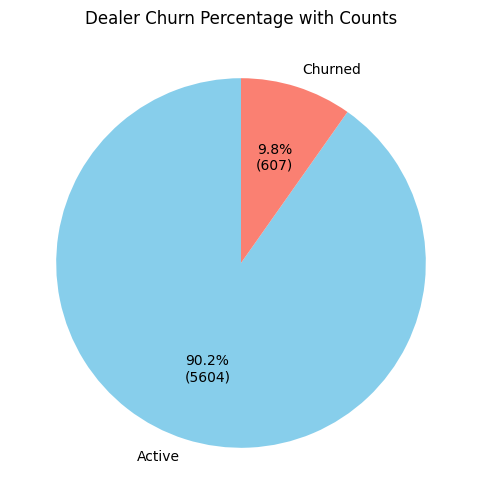

In [4]:
churn_counts  = df['churn_status'].value_counts()
labels = ["Active", "Churned"] if set(churn_counts.index) == {0,1} else churn_counts.index

# Function to show both percentage and count
def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count})"
    return inner_autopct

# Pie chart
plt.figure(figsize=(6,6))
churn_counts.plot(
    kind='pie',
    labels=labels,
    autopct=autopct_format(churn_counts),
    colors=['skyblue','salmon'],
    startangle=90
)
plt.title("Dealer Churn Percentage with Counts")
plt.ylabel("")
plt.show()

## Feature Overview


| **Date Range**           | **Features**                    | **Type**        |
|---------------------------|---------------------------------|-----------------|
| 12 months        | total sales                     | monetary        |
| 12 months        | total invoices                  | monetary        |
| 12 months        | total volume                    | monetary        |
| 12 months        | avg invoices                    | monetary        |
| 12 months        | avg sales                       | monetary        |
| 12 months        | avg volume                      | monetary        |
| 12 months        | avg sales in same territory     | monetary        |
| 12 months        | avg volume in same territory    | monetary        |
| 12 months        | avg orders in same territory    | monetary        |
| 12 months        | avg sales in same club          | monetary        |
| 12 months        | avg volume in same club         | monetary        |
| 12 months        | avg orders in same club         | monetary        |
| 12 months        | sas amount                      | behavioural     |
| 12 months        | rotation                        | behavioural     |
| 12 months        | terrwise rotation               | behavioural     |
| 12 months        | club-wise rotation              | behavioural     |
| 12 months        | exposure                        | monetary        |
| 12 months        | collection                      | monetary        |
| 12 months        | oustanding                      | monetary        |
| 12 months        | credit note value               | monetary        |
| 12 months        | unique claims                   | behavioural     |
| 12 months        | settled claims                  | behavioural     |
| 12 months        | active claims                   | behavioural     |
| 12 months        | visit count                     | behavioural     |
| 12 months        | offline order frequency         | behavioural     |
| 12 months        | online order frequency          | behavioural     |
| 12 months        | total order frequency           | behavioural     |
| Overall          | territory code                  | meta-data       |
| Overall          | dealer club category            | meta-data       |
| Overall          | dealership age                  | meta-data       |
| Overall          | avg_days_between_purchase       | behavioural     |
| Overall          | club demotion frequency         | behavioural     |
| Overall          | club no change frequency        | behavioural     |
| Overall          | club promotion frequency        | behavioural     |
| Overall          | counter shares of JK, MRF, APOLLO, CEAT, Others | behavioural |


## Creating Severity of Churn

- 120 = benchmark cutoff (maximum acceptable inactivity window).

    - Dealers billed within 120 days → still in the rescue zone.

    - Dealers above 120 days → beyond rescue.

    - Division → normalizes relative to the 120-day threshold.


In [5]:
# df['severity'] = round((df['last_billed_days'] / df['last_billed_days'].max()),4)

df['severity'] = round((df['last_billed_days'] / 120), 4)


## Logarithmic decay for severity
# half_life = 45  
# df['severity'] = (1 - np.exp(-np.log(2) * df['last_billed_days'] / half_life))

In [6]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categoric_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [7]:
df.drop('last_billed_days', axis=1, inplace=True)

In [8]:
## TODO: convert dealer_code to index & territory_code is str

In [9]:
df.to_csv("./complete/raw_data.csv",index=True)

In [10]:
df.drop(columns=['severity'],inplace=True)

## Encoding 

In [11]:
# df = pd.read_csv("./complete/raw_data.csv",index_col='dealer_code')

In [12]:
club_hierarchy = {
    'NS': 0,
    'STARTER': 1,
    'BLUE CLUB': 2,
    'GOLD PLUS CLUB': 3,
    'PLATINUM CLUB': 4,
    'DIAMOND CLUB':5,
    'ACER CLUB': 6,
    "CHAIRMAN'S CLUB":7,
    "CHAIRMAN ADVISORY": 8
}

df['dealer_club_category'] = df['dealer_club_category'].apply(
    lambda x: club_hierarchy.get(str(x).strip().upper(), np.nan)
)

In [13]:
## Encoding Zone
zone_dummies = pd.get_dummies(df['zone'], prefix='zone')
zone_dummies.replace({True:1,False:0},inplace=True)
df = pd.concat([df, zone_dummies], axis=1)
df.drop("zone",axis=1,inplace=True)

/var/folders/f7/p98720yn5kn5tvm33x4lx_89rys50w/T/ipykernel_47480/2693373867.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  zone_dummies.replace({True:1,False:0},inplace=True)


In [14]:
## Encoding Target Variable
df['churn_status']= df['churn_status'].replace({"Active":0,"Churned":1})

/var/folders/f7/p98720yn5kn5tvm33x4lx_89rys50w/T/ipykernel_47480/1737960587.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['churn_status']= df['churn_status'].replace({"Active":0,"Churned":1})


In [15]:
df['region_name'].unique()   

array(['FARIDABAD', 'DELHI', 'AGRA', 'VARANASI', 'MEERUT', 'KANPUR',
       'MUMBAI', 'NAGPUR', 'PUNE', 'JAIPUR', 'JODHPUR', 'Udaipur',
       'CHANDIGARH', 'JALANDHAR', 'INDORE', 'JABALPUR', 'RAIPUR',
       'Bilaspur', 'KOLKATA', 'Siliguri', 'GUWAHATI', 'PATNA',
       'JAMSHEDPUR', 'CUTTAK', 'AHMEDABAD', 'SURAT', 'RAJKOT', 'CHENNAI',
       'Madurai', 'SALEM', 'COCHIN', 'Calicut', 'H.BAD', 'VIJAYAWADA',
       'BNGLR', 'HUBLI', nan], dtype=object)

In [16]:
df['territory_code'].unique()   

array([321201., 321203., 321101., 321501., 321503., 321301., 321302.,
       321401., 311101., 311103., 312101., 375101., 375102., 373201.,
       373202., 372202., 372201., 374301., 373301., 374201., 371201.,
       371101., 371103., 372102., 372101., 372103., 374102., 374103.,
       374101., 374401., 373103., 373101., 373102., 731101., 732403.,
       731102., 732401., 732101., 732102., 733301., 733601., 734501.,
       733101., 733102., 733103., 733501., 733201., 733302., 734101.,
       734102., 734301., 734201., 734402., 734401., 741101., 361101.,
       361103., 361104., 364201., 361301., 362101., 361201., 362201.,
       362301., 361401., 362501., 363101., 363102., 363201., 364102.,
       364101., 364301., 312102., 733202., 351101., 352101., 341201.,
       341101., 332201., 332102., 332101., 331202., 332301., 331101.,
       331102., 331301., 711102., 711103., 711101., 711301., 712101.,
       712102., 712201., 712202., 712301., 713101., 713102., 713201.,
       729102., 7291

In [17]:
## Encoding Region & Territory code

region_dummies = pd.get_dummies(df['region_name'], prefix='region_name')
region_dummies.replace({True:1,False:0},inplace=True)
df = pd.concat([df, region_dummies], axis=1)
df.drop("region_name",axis=1,inplace=True)

/var/folders/f7/p98720yn5kn5tvm33x4lx_89rys50w/T/ipykernel_47480/3992873748.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  region_dummies.replace({True:1,False:0},inplace=True)


In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['territory_code_encoded'] = le.fit_transform(df['territory_code'])


In [19]:
df.drop('territory_code', axis=1, inplace=True)

In [20]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categoric_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [21]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [22]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['churn_status'])  # adjust if churn column name differs
y = df['churn_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:01:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [24]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (e.g., churn)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

print("Training Accuracy:", accuracy_score(y_train, y_train))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))  # if using probabilities

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Training Accuracy: 1.0
Testing Accuracy: 0.9823008849557522
ROC AUC Score: 0.9934665075647088

Confusion Matrix:
[[1110   12]
 [  10  111]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1122
           1       0.90      0.92      0.91       121

    accuracy                           0.98      1243
   macro avg       0.95      0.95      0.95      1243
weighted avg       0.98      0.98      0.98      1243



In [26]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0) 

In [27]:
X = X.replace(np.nan, 0 )

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

try:
    from xgboost import XGBClassifier
    use_xgb = True
except ImportError:
    use_xgb = False

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
}

if use_xgb:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



===== Decision Tree =====
Accuracy: 0.9629927594529365
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1122
           1       0.82      0.79      0.81       121

    accuracy                           0.96      1243
   macro avg       0.90      0.89      0.89      1243
weighted avg       0.96      0.96      0.96      1243


===== Random Forest =====
Accuracy: 0.9798873692679002
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1122
           1       0.91      0.88      0.90       121

    accuracy                           0.98      1243
   macro avg       0.95      0.94      0.94      1243
weighted avg       0.98      0.98      0.98      1243


===== Gradient Boosting =====
Accuracy: 0.9782783588093322
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1122
           1       0.89      0.89      0.89       121

    accura

/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



===== Logistic Regression =====
Accuracy: 0.8857602574416734
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1122
           1       0.45      0.83      0.58       121

    accuracy                           0.89      1243
   macro avg       0.72      0.86      0.76      1243
weighted avg       0.93      0.89      0.90      1243


===== SVM =====
Accuracy: 0.7699115044247787
              precision    recall  f1-score   support

           0       0.99      0.75      0.86      1122
           1       0.29      0.93      0.44       121

    accuracy                           0.77      1243
   macro avg       0.64      0.84      0.65      1243
weighted avg       0.92      0.77      0.81      1243



/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:01:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== XGBoost =====
Accuracy: 0.9806918744971842
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1122
           1       0.91      0.89      0.90       121

    accuracy                           0.98      1243
   macro avg       0.95      0.94      0.94      1243
weighted avg       0.98      0.98      0.98      1243




===== Decision Tree =====
Accuracy: 0.9629927594529365
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1122
           1       0.82      0.79      0.81       121

    accuracy                           0.96      1243
   macro avg       0.90      0.89      0.89      1243
weighted avg       0.96      0.96      0.96      1243



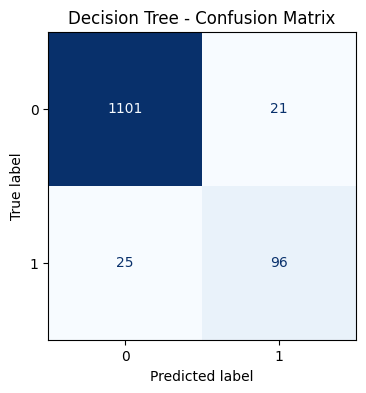


===== Random Forest =====
Accuracy: 0.9798873692679002
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1122
           1       0.91      0.88      0.90       121

    accuracy                           0.98      1243
   macro avg       0.95      0.94      0.94      1243
weighted avg       0.98      0.98      0.98      1243



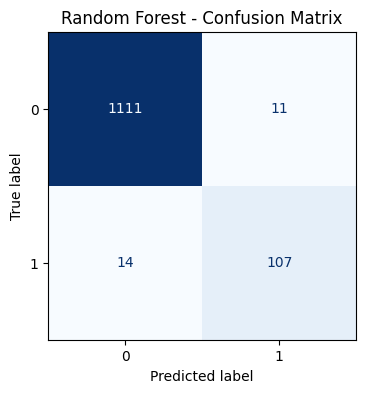


===== Gradient Boosting =====
Accuracy: 0.9782783588093322
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1122
           1       0.89      0.89      0.89       121

    accuracy                           0.98      1243
   macro avg       0.94      0.94      0.94      1243
weighted avg       0.98      0.98      0.98      1243



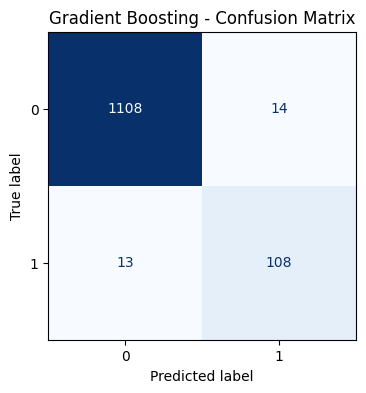


===== Logistic Regression =====
Accuracy: 0.8857602574416734
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1122
           1       0.45      0.83      0.58       121

    accuracy                           0.89      1243
   macro avg       0.72      0.86      0.76      1243
weighted avg       0.93      0.89      0.90      1243



/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


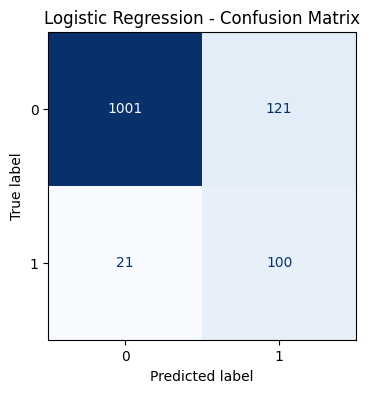


===== SVM =====
Accuracy: 0.7699115044247787
              precision    recall  f1-score   support

           0       0.99      0.75      0.86      1122
           1       0.29      0.93      0.44       121

    accuracy                           0.77      1243
   macro avg       0.64      0.84      0.65      1243
weighted avg       0.92      0.77      0.81      1243



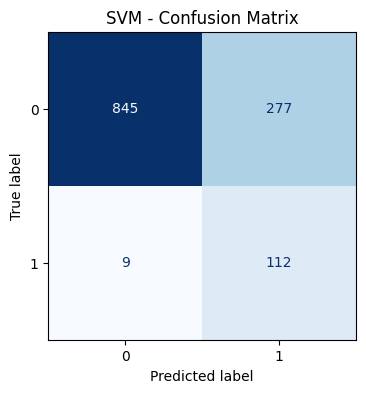

/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== XGBoost =====
Accuracy: 0.9806918744971842
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1122
           1       0.91      0.89      0.90       121

    accuracy                           0.98      1243
   macro avg       0.95      0.94      0.94      1243
weighted avg       0.98      0.98      0.98      1243



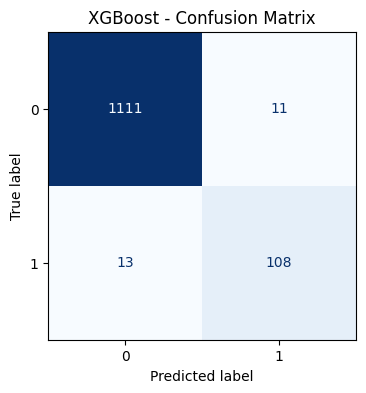

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train, evaluate, and plot confusion matrix
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


### Checking overfitting

In [30]:
# from sklearn.model_selection import RandomizedSearchCV
# import scipy.stats as st

# logreg_params = {
#     'C': st.loguniform(1e-2, 1e2),
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'solver': ['saga'],
#     'l1_ratio': st.uniform(0, 1)
# }

# random_search = RandomizedSearchCV(
#     logreg, 
#     logreg_params, 
#     n_iter=5, 
#     cv=5, 
#     scoring='f1', 
#     n_jobs=-1, 
#     random_state=42,
# )
# random_search.fit(X_train, y_train)


In [31]:
# Smaller param distributions for RandomizedSearch
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

# Narrow down params for GridSearch (after RandomizedSearch best result)
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# =====================================
# 4. RandomizedSearchCV
# =====================================
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,               # number of random combos
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("✅ Best Params from RandomizedSearch:", random_search.best_params_)
print("✅ Best F1 Score from RandomizedSearch:", random_search.best_score_)

# =====================================
# 5. GridSearchCV (refine search)
# =====================================
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("✅ Best Params from GridSearch:", grid_search.best_params_)
print("✅ Best F1 Score from GridSearch:", grid_search.best_score_)

# =====================================
# 6. Evaluate on test set
# =====================================
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== Final Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:02:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:02:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:02:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: User

✅ Best Params from RandomizedSearch: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}
✅ Best F1 Score from RandomizedSearch: 0.912242672786151
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:02:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:02:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:02:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: User

✅ Best Params from GridSearch: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
✅ Best F1 Score from GridSearch: 0.9135469199426087

=== Final Test Performance ===
Accuracy: 0.9831053901850362
F1 Score: 0.9135802469135802
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1122
           1       0.91      0.92      0.91       121

    accuracy                           0.98      1243
   macro avg       0.95      0.95      0.95      1243
weighted avg       0.98      0.98      0.98      1243



In [32]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV
# import numpy as np

# # Parameter distribution for RandomizedSearchCV
# rf_params = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

# rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# rf_search = RandomizedSearchCV(rf, rf_params, n_iter=50, cv=5, scoring='f1', n_jobs=-1, random_state=42)
# rf_search.fit(X_train, y_train)

# print("Best Random Forest params:", rf_search.best_params_)
# print("Best F1 score:", rf_search.best_score_)


In [33]:
# X_test.drop(columns=['confidence_score','pred_label'], inplace=True)

In [146]:
# -------- Predictions --------
y_train_pred = best_model.predict(X_train)
y_test_pred  = best_model.predict(X_test)

# -------- Metrics --------
train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test,  y_test_pred)
# train_auc = roc_auc_score(y_train, y_train_score)
# test_auc  = roc_auc_score(y_test,  y_test_score)

print(f"Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
# print(f"Train ROC-AUC : {train_auc:.4f} | Test ROC-AUC : {test_auc:.4f}\n")

print("=== Classification Report (Test) ===")
print(classification_report(y_test, y_test_pred, digits=3))

# -------- Confusion Matrix (Test) --------
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Active","Churned"],normalize=True)
fig, ax = plt.subplots(figsize=(5.5, 4))
disp.plot(ax=ax, values_format="d", colorbar=True)
ax.set_title("Confusion Matrix - Best XGB Model")
plt.tight_layout()
plt.show()


## AUC -ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (Churned = 1)
y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob  = best_model.predict_proba(X_test)[:, 1]

# Compute ROC-AUC
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc  = roc_auc_score(y_test,  y_test_prob)

# Compute ROC Curve points
fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_prob)
fpr_te, tpr_te, _ = roc_curve(y_test,  y_test_prob)

# Plot ROC Curve
plt.figure(figsize=(6.5, 5.5))
plt.plot(fpr_tr, tpr_tr, label=f"Train AUC = {train_auc:.3f}")
plt.plot(fpr_te, tpr_te, label=f"Test  AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best XGB Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



ValueError: feature_names mismatch: ['total_sales_cm-1', 'total_sales_cm-10', 'total_sales_cm-11', 'total_sales_cm-12', 'total_sales_cm-2', 'total_sales_cm-3', 'total_sales_cm-4', 'total_sales_cm-5', 'total_sales_cm-6', 'total_sales_cm-7', 'total_sales_cm-8', 'total_sales_cm-9', 'total_invoices_cm-1', 'total_invoices_cm-10', 'total_invoices_cm-11', 'total_invoices_cm-12', 'total_invoices_cm-2', 'total_invoices_cm-3', 'total_invoices_cm-4', 'total_invoices_cm-5', 'total_invoices_cm-6', 'total_invoices_cm-7', 'total_invoices_cm-8', 'total_invoices_cm-9', 'total_units_cm-1', 'total_units_cm-10', 'total_units_cm-11', 'total_units_cm-12', 'total_units_cm-2', 'total_units_cm-3', 'total_units_cm-4', 'total_units_cm-5', 'total_units_cm-6', 'total_units_cm-7', 'total_units_cm-8', 'total_units_cm-9', 'avg_invoices_cm-1', 'avg_invoices_cm-10', 'avg_invoices_cm-11', 'avg_invoices_cm-12', 'avg_invoices_cm-2', 'avg_invoices_cm-3', 'avg_invoices_cm-4', 'avg_invoices_cm-5', 'avg_invoices_cm-6', 'avg_invoices_cm-7', 'avg_invoices_cm-8', 'avg_invoices_cm-9', 'avg_sales_cm-1', 'avg_sales_cm-10', 'avg_sales_cm-11', 'avg_sales_cm-12', 'avg_sales_cm-2', 'avg_sales_cm-3', 'avg_sales_cm-4', 'avg_sales_cm-5', 'avg_sales_cm-6', 'avg_sales_cm-7', 'avg_sales_cm-8', 'avg_sales_cm-9', 'avg_units_purchased_cm-1', 'avg_units_purchased_cm-10', 'avg_units_purchased_cm-11', 'avg_units_purchased_cm-12', 'avg_units_purchased_cm-2', 'avg_units_purchased_cm-3', 'avg_units_purchased_cm-4', 'avg_units_purchased_cm-5', 'avg_units_purchased_cm-6', 'avg_units_purchased_cm-7', 'avg_units_purchased_cm-8', 'avg_units_purchased_cm-9', 'avg_sales_of_dealers_in_same_territory_cm-1', 'avg_sales_of_dealers_in_same_territory_cm-10', 'avg_sales_of_dealers_in_same_territory_cm-11', 'avg_sales_of_dealers_in_same_territory_cm-12', 'avg_sales_of_dealers_in_same_territory_cm-2', 'avg_sales_of_dealers_in_same_territory_cm-3', 'avg_sales_of_dealers_in_same_territory_cm-4', 'avg_sales_of_dealers_in_same_territory_cm-5', 'avg_sales_of_dealers_in_same_territory_cm-6', 'avg_sales_of_dealers_in_same_territory_cm-7', 'avg_sales_of_dealers_in_same_territory_cm-8', 'avg_sales_of_dealers_in_same_territory_cm-9', 'avg_orders_of_dealers_in_same_territory_cm-1', 'avg_orders_of_dealers_in_same_territory_cm-10', 'avg_orders_of_dealers_in_same_territory_cm-11', 'avg_orders_of_dealers_in_same_territory_cm-12', 'avg_orders_of_dealers_in_same_territory_cm-2', 'avg_orders_of_dealers_in_same_territory_cm-3', 'avg_orders_of_dealers_in_same_territory_cm-4', 'avg_orders_of_dealers_in_same_territory_cm-5', 'avg_orders_of_dealers_in_same_territory_cm-6', 'avg_orders_of_dealers_in_same_territory_cm-7', 'avg_orders_of_dealers_in_same_territory_cm-8', 'avg_orders_of_dealers_in_same_territory_cm-9', 'avg_units_of_dealers_in_same_territory_cm-1', 'avg_units_of_dealers_in_same_territory_cm-10', 'avg_units_of_dealers_in_same_territory_cm-11', 'avg_units_of_dealers_in_same_territory_cm-12', 'avg_units_of_dealers_in_same_territory_cm-2', 'avg_units_of_dealers_in_same_territory_cm-3', 'avg_units_of_dealers_in_same_territory_cm-4', 'avg_units_of_dealers_in_same_territory_cm-5', 'avg_units_of_dealers_in_same_territory_cm-6', 'avg_units_of_dealers_in_same_territory_cm-7', 'avg_units_of_dealers_in_same_territory_cm-8', 'avg_units_of_dealers_in_same_territory_cm-9', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-1', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-10', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-11', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-12', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-2', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-3', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-4', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-5', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-6', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-7', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-8', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-9', 'avg_orders_of_dealers_in_dealer_club_category_cm-1', 'avg_orders_of_dealers_in_dealer_club_category_cm-10', 'avg_orders_of_dealers_in_dealer_club_category_cm-11', 'avg_orders_of_dealers_in_dealer_club_category_cm-12', 'avg_orders_of_dealers_in_dealer_club_category_cm-2', 'avg_orders_of_dealers_in_dealer_club_category_cm-3', 'avg_orders_of_dealers_in_dealer_club_category_cm-4', 'avg_orders_of_dealers_in_dealer_club_category_cm-5', 'avg_orders_of_dealers_in_dealer_club_category_cm-6', 'avg_orders_of_dealers_in_dealer_club_category_cm-7', 'avg_orders_of_dealers_in_dealer_club_category_cm-8', 'avg_orders_of_dealers_in_dealer_club_category_cm-9', 'avg_units_of_dealers_in_dealer_club_category_cm-1', 'avg_units_of_dealers_in_dealer_club_category_cm-10', 'avg_units_of_dealers_in_dealer_club_category_cm-11', 'avg_units_of_dealers_in_dealer_club_category_cm-12', 'avg_units_of_dealers_in_dealer_club_category_cm-2', 'avg_units_of_dealers_in_dealer_club_category_cm-3', 'avg_units_of_dealers_in_dealer_club_category_cm-4', 'avg_units_of_dealers_in_dealer_club_category_cm-5', 'avg_units_of_dealers_in_dealer_club_category_cm-6', 'avg_units_of_dealers_in_dealer_club_category_cm-7', 'avg_units_of_dealers_in_dealer_club_category_cm-8', 'avg_units_of_dealers_in_dealer_club_category_cm-9', 'sas_amount_cm-1', 'sas_amount_cm-10', 'sas_amount_cm-11', 'sas_amount_cm-12', 'sas_amount_cm-2', 'sas_amount_cm-3', 'sas_amount_cm-4', 'sas_amount_cm-5', 'sas_amount_cm-6', 'sas_amount_cm-7', 'sas_amount_cm-8', 'sas_amount_cm-9', 'rotation_cm-1', 'rotation_cm-10', 'rotation_cm-11', 'rotation_cm-12', 'rotation_cm-2', 'rotation_cm-3', 'rotation_cm-4', 'rotation_cm-5', 'rotation_cm-6', 'rotation_cm-7', 'rotation_cm-8', 'rotation_cm-9', 'terrwise_rotation_cm-1', 'terrwise_rotation_cm-10', 'terrwise_rotation_cm-11', 'terrwise_rotation_cm-12', 'terrwise_rotation_cm-2', 'terrwise_rotation_cm-3', 'terrwise_rotation_cm-4', 'terrwise_rotation_cm-5', 'terrwise_rotation_cm-6', 'terrwise_rotation_cm-7', 'terrwise_rotation_cm-8', 'terrwise_rotation_cm-9', 'dealerclub_wise_rotation_cm-1', 'dealerclub_wise_rotation_cm-10', 'dealerclub_wise_rotation_cm-11', 'dealerclub_wise_rotation_cm-12', 'dealerclub_wise_rotation_cm-2', 'dealerclub_wise_rotation_cm-3', 'dealerclub_wise_rotation_cm-4', 'dealerclub_wise_rotation_cm-5', 'dealerclub_wise_rotation_cm-6', 'dealerclub_wise_rotation_cm-7', 'dealerclub_wise_rotation_cm-8', 'dealerclub_wise_rotation_cm-9', 'exposure_cm-1', 'exposure_cm-10', 'exposure_cm-11', 'exposure_cm-12', 'exposure_cm-2', 'exposure_cm-3', 'exposure_cm-4', 'exposure_cm-5', 'exposure_cm-6', 'exposure_cm-7', 'exposure_cm-8', 'exposure_cm-9', 'collection_cm-1', 'collection_cm-10', 'collection_cm-11', 'collection_cm-12', 'collection_cm-2', 'collection_cm-3', 'collection_cm-4', 'collection_cm-5', 'collection_cm-6', 'collection_cm-7', 'collection_cm-8', 'collection_cm-9', 'outstanding_cm-1', 'outstanding_cm-10', 'outstanding_cm-11', 'outstanding_cm-12', 'outstanding_cm-2', 'outstanding_cm-3', 'outstanding_cm-4', 'outstanding_cm-5', 'outstanding_cm-6', 'outstanding_cm-7', 'outstanding_cm-8', 'outstanding_cm-9', 'outstanding_0_30_cm-1', 'outstanding_0_30_cm-10', 'outstanding_0_30_cm-11', 'outstanding_0_30_cm-12', 'outstanding_0_30_cm-2', 'outstanding_0_30_cm-3', 'outstanding_0_30_cm-4', 'outstanding_0_30_cm-5', 'outstanding_0_30_cm-6', 'outstanding_0_30_cm-7', 'outstanding_0_30_cm-8', 'outstanding_0_30_cm-9', 'outstanding_30_45_cm-1', 'outstanding_30_45_cm-10', 'outstanding_30_45_cm-11', 'outstanding_30_45_cm-12', 'outstanding_30_45_cm-2', 'outstanding_30_45_cm-3', 'outstanding_30_45_cm-4', 'outstanding_30_45_cm-5', 'outstanding_30_45_cm-6', 'outstanding_30_45_cm-7', 'outstanding_30_45_cm-8', 'outstanding_30_45_cm-9', 'outstanding_45_60_cm-1', 'outstanding_45_60_cm-10', 'outstanding_45_60_cm-11', 'outstanding_45_60_cm-12', 'outstanding_45_60_cm-2', 'outstanding_45_60_cm-3', 'outstanding_45_60_cm-4', 'outstanding_45_60_cm-5', 'outstanding_45_60_cm-6', 'outstanding_45_60_cm-7', 'outstanding_45_60_cm-8', 'outstanding_45_60_cm-9', 'outstanding_60+_cm-1', 'outstanding_60+_cm-10', 'outstanding_60+_cm-11', 'outstanding_60+_cm-12', 'outstanding_60+_cm-2', 'outstanding_60+_cm-3', 'outstanding_60+_cm-4', 'outstanding_60+_cm-5', 'outstanding_60+_cm-6', 'outstanding_60+_cm-7', 'outstanding_60+_cm-8', 'outstanding_60+_cm-9', 'total_credit_note_value_cm-1', 'total_credit_note_value_cm-10', 'total_credit_note_value_cm-11', 'total_credit_note_value_cm-12', 'total_credit_note_value_cm-2', 'total_credit_note_value_cm-3', 'total_credit_note_value_cm-4', 'total_credit_note_value_cm-5', 'total_credit_note_value_cm-6', 'total_credit_note_value_cm-7', 'total_credit_note_value_cm-8', 'total_credit_note_value_cm-9', 'avg_credit_note_value_cm-1', 'avg_credit_note_value_cm-10', 'avg_credit_note_value_cm-11', 'avg_credit_note_value_cm-12', 'avg_credit_note_value_cm-2', 'avg_credit_note_value_cm-3', 'avg_credit_note_value_cm-4', 'avg_credit_note_value_cm-5', 'avg_credit_note_value_cm-6', 'avg_credit_note_value_cm-7', 'avg_credit_note_value_cm-8', 'avg_credit_note_value_cm-9', 'offline_cm-1', 'offline_cm-10', 'offline_cm-11', 'offline_cm-12', 'offline_cm-2', 'offline_cm-3', 'offline_cm-4', 'offline_cm-5', 'offline_cm-6', 'offline_cm-7', 'offline_cm-8', 'offline_cm-9', 'online_cm-1', 'online_cm-10', 'online_cm-11', 'online_cm-12', 'online_cm-2', 'online_cm-3', 'online_cm-4', 'online_cm-5', 'online_cm-6', 'online_cm-7', 'online_cm-8', 'online_cm-9', 'total_orders_cm-1', 'total_orders_cm-10', 'total_orders_cm-11', 'total_orders_cm-12', 'total_orders_cm-2', 'total_orders_cm-3', 'total_orders_cm-4', 'total_orders_cm-5', 'total_orders_cm-6', 'total_orders_cm-7', 'total_orders_cm-8', 'total_orders_cm-9', 'unique_claims_cm-1', 'unique_claims_cm-10', 'unique_claims_cm-11', 'unique_claims_cm-12', 'unique_claims_cm-2', 'unique_claims_cm-3', 'unique_claims_cm-4', 'unique_claims_cm-5', 'unique_claims_cm-6', 'unique_claims_cm-7', 'unique_claims_cm-8', 'unique_claims_cm-9', 'settled_claims_cm-1', 'settled_claims_cm-10', 'settled_claims_cm-11', 'settled_claims_cm-12', 'settled_claims_cm-2', 'settled_claims_cm-3', 'settled_claims_cm-4', 'settled_claims_cm-5', 'settled_claims_cm-6', 'settled_claims_cm-7', 'settled_claims_cm-8', 'settled_claims_cm-9', 'active_claims_cm-1', 'active_claims_cm-10', 'active_claims_cm-11', 'active_claims_cm-12', 'active_claims_cm-2', 'active_claims_cm-3', 'active_claims_cm-4', 'active_claims_cm-5', 'active_claims_cm-6', 'active_claims_cm-7', 'active_claims_cm-8', 'active_claims_cm-9', 'visit_count_cm-1', 'visit_count_cm-10', 'visit_count_cm-11', 'visit_count_cm-12', 'visit_count_cm-2', 'visit_count_cm-3', 'visit_count_cm-4', 'visit_count_cm-5', 'visit_count_cm-6', 'visit_count_cm-7', 'visit_count_cm-8', 'visit_count_cm-9', 'dealer_club_category', 'dealership_age', 'avg_days_between_purchase', 'Demoted', 'No Change', 'Promoted', 'jktil', 'apollo', 'mrf', 'ceat', 'oth.', 'total', 'jktil_share', 'apollo_share', 'mrf_share', 'ceat_share', 'oth._share', 'dealer_count', 'zone_Central Zone', 'zone_EAST', 'zone_NORTH', 'zone_SOUTH', 'zone_South Zone - II', 'zone_WEST', 'region_name_AGRA', 'region_name_AHMEDABAD', 'region_name_BNGLR', 'region_name_Bilaspur', 'region_name_CHANDIGARH', 'region_name_CHENNAI', 'region_name_COCHIN', 'region_name_CUTTAK', 'region_name_Calicut', 'region_name_DELHI', 'region_name_FARIDABAD', 'region_name_GUWAHATI', 'region_name_H.BAD', 'region_name_HUBLI', 'region_name_INDORE', 'region_name_JABALPUR', 'region_name_JAIPUR', 'region_name_JALANDHAR', 'region_name_JAMSHEDPUR', 'region_name_JODHPUR', 'region_name_KANPUR', 'region_name_KOLKATA', 'region_name_MEERUT', 'region_name_MUMBAI', 'region_name_Madurai', 'region_name_NAGPUR', 'region_name_PATNA', 'region_name_PUNE', 'region_name_RAIPUR', 'region_name_RAJKOT', 'region_name_SALEM', 'region_name_SURAT', 'region_name_Siliguri', 'region_name_Udaipur', 'region_name_VARANASI', 'region_name_VIJAYAWADA', 'territory_code_encoded'] ['dealer_code', 'total_sales_cm-1', 'total_sales_cm-10', 'total_sales_cm-11', 'total_sales_cm-12', 'total_sales_cm-2', 'total_sales_cm-3', 'total_sales_cm-4', 'total_sales_cm-5', 'total_sales_cm-6', 'total_sales_cm-7', 'total_sales_cm-8', 'total_sales_cm-9', 'total_invoices_cm-1', 'total_invoices_cm-10', 'total_invoices_cm-11', 'total_invoices_cm-12', 'total_invoices_cm-2', 'total_invoices_cm-3', 'total_invoices_cm-4', 'total_invoices_cm-5', 'total_invoices_cm-6', 'total_invoices_cm-7', 'total_invoices_cm-8', 'total_invoices_cm-9', 'total_units_cm-1', 'total_units_cm-10', 'total_units_cm-11', 'total_units_cm-12', 'total_units_cm-2', 'total_units_cm-3', 'total_units_cm-4', 'total_units_cm-5', 'total_units_cm-6', 'total_units_cm-7', 'total_units_cm-8', 'total_units_cm-9', 'avg_invoices_cm-1', 'avg_invoices_cm-10', 'avg_invoices_cm-11', 'avg_invoices_cm-12', 'avg_invoices_cm-2', 'avg_invoices_cm-3', 'avg_invoices_cm-4', 'avg_invoices_cm-5', 'avg_invoices_cm-6', 'avg_invoices_cm-7', 'avg_invoices_cm-8', 'avg_invoices_cm-9', 'avg_sales_cm-1', 'avg_sales_cm-10', 'avg_sales_cm-11', 'avg_sales_cm-12', 'avg_sales_cm-2', 'avg_sales_cm-3', 'avg_sales_cm-4', 'avg_sales_cm-5', 'avg_sales_cm-6', 'avg_sales_cm-7', 'avg_sales_cm-8', 'avg_sales_cm-9', 'avg_units_purchased_cm-1', 'avg_units_purchased_cm-10', 'avg_units_purchased_cm-11', 'avg_units_purchased_cm-12', 'avg_units_purchased_cm-2', 'avg_units_purchased_cm-3', 'avg_units_purchased_cm-4', 'avg_units_purchased_cm-5', 'avg_units_purchased_cm-6', 'avg_units_purchased_cm-7', 'avg_units_purchased_cm-8', 'avg_units_purchased_cm-9', 'avg_sales_of_dealers_in_same_territory_cm-1', 'avg_sales_of_dealers_in_same_territory_cm-10', 'avg_sales_of_dealers_in_same_territory_cm-11', 'avg_sales_of_dealers_in_same_territory_cm-12', 'avg_sales_of_dealers_in_same_territory_cm-2', 'avg_sales_of_dealers_in_same_territory_cm-3', 'avg_sales_of_dealers_in_same_territory_cm-4', 'avg_sales_of_dealers_in_same_territory_cm-5', 'avg_sales_of_dealers_in_same_territory_cm-6', 'avg_sales_of_dealers_in_same_territory_cm-7', 'avg_sales_of_dealers_in_same_territory_cm-8', 'avg_sales_of_dealers_in_same_territory_cm-9', 'avg_orders_of_dealers_in_same_territory_cm-1', 'avg_orders_of_dealers_in_same_territory_cm-10', 'avg_orders_of_dealers_in_same_territory_cm-11', 'avg_orders_of_dealers_in_same_territory_cm-12', 'avg_orders_of_dealers_in_same_territory_cm-2', 'avg_orders_of_dealers_in_same_territory_cm-3', 'avg_orders_of_dealers_in_same_territory_cm-4', 'avg_orders_of_dealers_in_same_territory_cm-5', 'avg_orders_of_dealers_in_same_territory_cm-6', 'avg_orders_of_dealers_in_same_territory_cm-7', 'avg_orders_of_dealers_in_same_territory_cm-8', 'avg_orders_of_dealers_in_same_territory_cm-9', 'avg_units_of_dealers_in_same_territory_cm-1', 'avg_units_of_dealers_in_same_territory_cm-10', 'avg_units_of_dealers_in_same_territory_cm-11', 'avg_units_of_dealers_in_same_territory_cm-12', 'avg_units_of_dealers_in_same_territory_cm-2', 'avg_units_of_dealers_in_same_territory_cm-3', 'avg_units_of_dealers_in_same_territory_cm-4', 'avg_units_of_dealers_in_same_territory_cm-5', 'avg_units_of_dealers_in_same_territory_cm-6', 'avg_units_of_dealers_in_same_territory_cm-7', 'avg_units_of_dealers_in_same_territory_cm-8', 'avg_units_of_dealers_in_same_territory_cm-9', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-1', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-10', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-11', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-12', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-2', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-3', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-4', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-5', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-6', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-7', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-8', 'avg_sales_of_dealers_in_same_dealer_club_category_cm-9', 'avg_orders_of_dealers_in_dealer_club_category_cm-1', 'avg_orders_of_dealers_in_dealer_club_category_cm-10', 'avg_orders_of_dealers_in_dealer_club_category_cm-11', 'avg_orders_of_dealers_in_dealer_club_category_cm-12', 'avg_orders_of_dealers_in_dealer_club_category_cm-2', 'avg_orders_of_dealers_in_dealer_club_category_cm-3', 'avg_orders_of_dealers_in_dealer_club_category_cm-4', 'avg_orders_of_dealers_in_dealer_club_category_cm-5', 'avg_orders_of_dealers_in_dealer_club_category_cm-6', 'avg_orders_of_dealers_in_dealer_club_category_cm-7', 'avg_orders_of_dealers_in_dealer_club_category_cm-8', 'avg_orders_of_dealers_in_dealer_club_category_cm-9', 'avg_units_of_dealers_in_dealer_club_category_cm-1', 'avg_units_of_dealers_in_dealer_club_category_cm-10', 'avg_units_of_dealers_in_dealer_club_category_cm-11', 'avg_units_of_dealers_in_dealer_club_category_cm-12', 'avg_units_of_dealers_in_dealer_club_category_cm-2', 'avg_units_of_dealers_in_dealer_club_category_cm-3', 'avg_units_of_dealers_in_dealer_club_category_cm-4', 'avg_units_of_dealers_in_dealer_club_category_cm-5', 'avg_units_of_dealers_in_dealer_club_category_cm-6', 'avg_units_of_dealers_in_dealer_club_category_cm-7', 'avg_units_of_dealers_in_dealer_club_category_cm-8', 'avg_units_of_dealers_in_dealer_club_category_cm-9', 'sas_amount_cm-1', 'sas_amount_cm-10', 'sas_amount_cm-11', 'sas_amount_cm-12', 'sas_amount_cm-2', 'sas_amount_cm-3', 'sas_amount_cm-4', 'sas_amount_cm-5', 'sas_amount_cm-6', 'sas_amount_cm-7', 'sas_amount_cm-8', 'sas_amount_cm-9', 'rotation_cm-1', 'rotation_cm-10', 'rotation_cm-11', 'rotation_cm-12', 'rotation_cm-2', 'rotation_cm-3', 'rotation_cm-4', 'rotation_cm-5', 'rotation_cm-6', 'rotation_cm-7', 'rotation_cm-8', 'rotation_cm-9', 'terrwise_rotation_cm-1', 'terrwise_rotation_cm-10', 'terrwise_rotation_cm-11', 'terrwise_rotation_cm-12', 'terrwise_rotation_cm-2', 'terrwise_rotation_cm-3', 'terrwise_rotation_cm-4', 'terrwise_rotation_cm-5', 'terrwise_rotation_cm-6', 'terrwise_rotation_cm-7', 'terrwise_rotation_cm-8', 'terrwise_rotation_cm-9', 'dealerclub_wise_rotation_cm-1', 'dealerclub_wise_rotation_cm-10', 'dealerclub_wise_rotation_cm-11', 'dealerclub_wise_rotation_cm-12', 'dealerclub_wise_rotation_cm-2', 'dealerclub_wise_rotation_cm-3', 'dealerclub_wise_rotation_cm-4', 'dealerclub_wise_rotation_cm-5', 'dealerclub_wise_rotation_cm-6', 'dealerclub_wise_rotation_cm-7', 'dealerclub_wise_rotation_cm-8', 'dealerclub_wise_rotation_cm-9', 'exposure_cm-1', 'exposure_cm-10', 'exposure_cm-11', 'exposure_cm-12', 'exposure_cm-2', 'exposure_cm-3', 'exposure_cm-4', 'exposure_cm-5', 'exposure_cm-6', 'exposure_cm-7', 'exposure_cm-8', 'exposure_cm-9', 'collection_cm-1', 'collection_cm-10', 'collection_cm-11', 'collection_cm-12', 'collection_cm-2', 'collection_cm-3', 'collection_cm-4', 'collection_cm-5', 'collection_cm-6', 'collection_cm-7', 'collection_cm-8', 'collection_cm-9', 'outstanding_cm-1', 'outstanding_cm-10', 'outstanding_cm-11', 'outstanding_cm-12', 'outstanding_cm-2', 'outstanding_cm-3', 'outstanding_cm-4', 'outstanding_cm-5', 'outstanding_cm-6', 'outstanding_cm-7', 'outstanding_cm-8', 'outstanding_cm-9', 'outstanding_0_30_cm-1', 'outstanding_0_30_cm-10', 'outstanding_0_30_cm-11', 'outstanding_0_30_cm-12', 'outstanding_0_30_cm-2', 'outstanding_0_30_cm-3', 'outstanding_0_30_cm-4', 'outstanding_0_30_cm-5', 'outstanding_0_30_cm-6', 'outstanding_0_30_cm-7', 'outstanding_0_30_cm-8', 'outstanding_0_30_cm-9', 'outstanding_30_45_cm-1', 'outstanding_30_45_cm-10', 'outstanding_30_45_cm-11', 'outstanding_30_45_cm-12', 'outstanding_30_45_cm-2', 'outstanding_30_45_cm-3', 'outstanding_30_45_cm-4', 'outstanding_30_45_cm-5', 'outstanding_30_45_cm-6', 'outstanding_30_45_cm-7', 'outstanding_30_45_cm-8', 'outstanding_30_45_cm-9', 'outstanding_45_60_cm-1', 'outstanding_45_60_cm-10', 'outstanding_45_60_cm-11', 'outstanding_45_60_cm-12', 'outstanding_45_60_cm-2', 'outstanding_45_60_cm-3', 'outstanding_45_60_cm-4', 'outstanding_45_60_cm-5', 'outstanding_45_60_cm-6', 'outstanding_45_60_cm-7', 'outstanding_45_60_cm-8', 'outstanding_45_60_cm-9', 'outstanding_60+_cm-1', 'outstanding_60+_cm-10', 'outstanding_60+_cm-11', 'outstanding_60+_cm-12', 'outstanding_60+_cm-2', 'outstanding_60+_cm-3', 'outstanding_60+_cm-4', 'outstanding_60+_cm-5', 'outstanding_60+_cm-6', 'outstanding_60+_cm-7', 'outstanding_60+_cm-8', 'outstanding_60+_cm-9', 'total_credit_note_value_cm-1', 'total_credit_note_value_cm-10', 'total_credit_note_value_cm-11', 'total_credit_note_value_cm-12', 'total_credit_note_value_cm-2', 'total_credit_note_value_cm-3', 'total_credit_note_value_cm-4', 'total_credit_note_value_cm-5', 'total_credit_note_value_cm-6', 'total_credit_note_value_cm-7', 'total_credit_note_value_cm-8', 'total_credit_note_value_cm-9', 'avg_credit_note_value_cm-1', 'avg_credit_note_value_cm-10', 'avg_credit_note_value_cm-11', 'avg_credit_note_value_cm-12', 'avg_credit_note_value_cm-2', 'avg_credit_note_value_cm-3', 'avg_credit_note_value_cm-4', 'avg_credit_note_value_cm-5', 'avg_credit_note_value_cm-6', 'avg_credit_note_value_cm-7', 'avg_credit_note_value_cm-8', 'avg_credit_note_value_cm-9', 'offline_cm-1', 'offline_cm-10', 'offline_cm-11', 'offline_cm-12', 'offline_cm-2', 'offline_cm-3', 'offline_cm-4', 'offline_cm-5', 'offline_cm-6', 'offline_cm-7', 'offline_cm-8', 'offline_cm-9', 'online_cm-1', 'online_cm-10', 'online_cm-11', 'online_cm-12', 'online_cm-2', 'online_cm-3', 'online_cm-4', 'online_cm-5', 'online_cm-6', 'online_cm-7', 'online_cm-8', 'online_cm-9', 'total_orders_cm-1', 'total_orders_cm-10', 'total_orders_cm-11', 'total_orders_cm-12', 'total_orders_cm-2', 'total_orders_cm-3', 'total_orders_cm-4', 'total_orders_cm-5', 'total_orders_cm-6', 'total_orders_cm-7', 'total_orders_cm-8', 'total_orders_cm-9', 'unique_claims_cm-1', 'unique_claims_cm-10', 'unique_claims_cm-11', 'unique_claims_cm-12', 'unique_claims_cm-2', 'unique_claims_cm-3', 'unique_claims_cm-4', 'unique_claims_cm-5', 'unique_claims_cm-6', 'unique_claims_cm-7', 'unique_claims_cm-8', 'unique_claims_cm-9', 'settled_claims_cm-1', 'settled_claims_cm-10', 'settled_claims_cm-11', 'settled_claims_cm-12', 'settled_claims_cm-2', 'settled_claims_cm-3', 'settled_claims_cm-4', 'settled_claims_cm-5', 'settled_claims_cm-6', 'settled_claims_cm-7', 'settled_claims_cm-8', 'settled_claims_cm-9', 'active_claims_cm-1', 'active_claims_cm-10', 'active_claims_cm-11', 'active_claims_cm-12', 'active_claims_cm-2', 'active_claims_cm-3', 'active_claims_cm-4', 'active_claims_cm-5', 'active_claims_cm-6', 'active_claims_cm-7', 'active_claims_cm-8', 'active_claims_cm-9', 'visit_count_cm-1', 'visit_count_cm-10', 'visit_count_cm-11', 'visit_count_cm-12', 'visit_count_cm-2', 'visit_count_cm-3', 'visit_count_cm-4', 'visit_count_cm-5', 'visit_count_cm-6', 'visit_count_cm-7', 'visit_count_cm-8', 'visit_count_cm-9', 'dealer_club_category', 'dealership_age', 'avg_days_between_purchase', 'Demoted', 'No Change', 'Promoted', 'jktil', 'apollo', 'mrf', 'ceat', 'oth.', 'total', 'jktil_share', 'apollo_share', 'mrf_share', 'ceat_share', 'oth._share', 'dealer_count', 'zone_Central Zone', 'zone_EAST', 'zone_NORTH', 'zone_SOUTH', 'zone_South Zone - II', 'zone_WEST', 'region_name_AGRA', 'region_name_AHMEDABAD', 'region_name_BNGLR', 'region_name_Bilaspur', 'region_name_CHANDIGARH', 'region_name_CHENNAI', 'region_name_COCHIN', 'region_name_CUTTAK', 'region_name_Calicut', 'region_name_DELHI', 'region_name_FARIDABAD', 'region_name_GUWAHATI', 'region_name_H.BAD', 'region_name_HUBLI', 'region_name_INDORE', 'region_name_JABALPUR', 'region_name_JAIPUR', 'region_name_JALANDHAR', 'region_name_JAMSHEDPUR', 'region_name_JODHPUR', 'region_name_KANPUR', 'region_name_KOLKATA', 'region_name_MEERUT', 'region_name_MUMBAI', 'region_name_Madurai', 'region_name_NAGPUR', 'region_name_PATNA', 'region_name_PUNE', 'region_name_RAIPUR', 'region_name_RAJKOT', 'region_name_SALEM', 'region_name_SURAT', 'region_name_Siliguri', 'region_name_Udaipur', 'region_name_VARANASI', 'region_name_VIJAYAWADA', 'territory_code_encoded', 'last_billed_days']
training data did not have the following fields: last_billed_days, dealer_code

## Adding Explainablity

In [36]:
df.shape, X_test.shape, X_train.shape, 

((6211, 446), (1243, 445), (4968, 445))

In [ ]:
df['churn_status'].value_counts()

churn_status
0    5604
1     607
Name: count, dtype: int64

/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


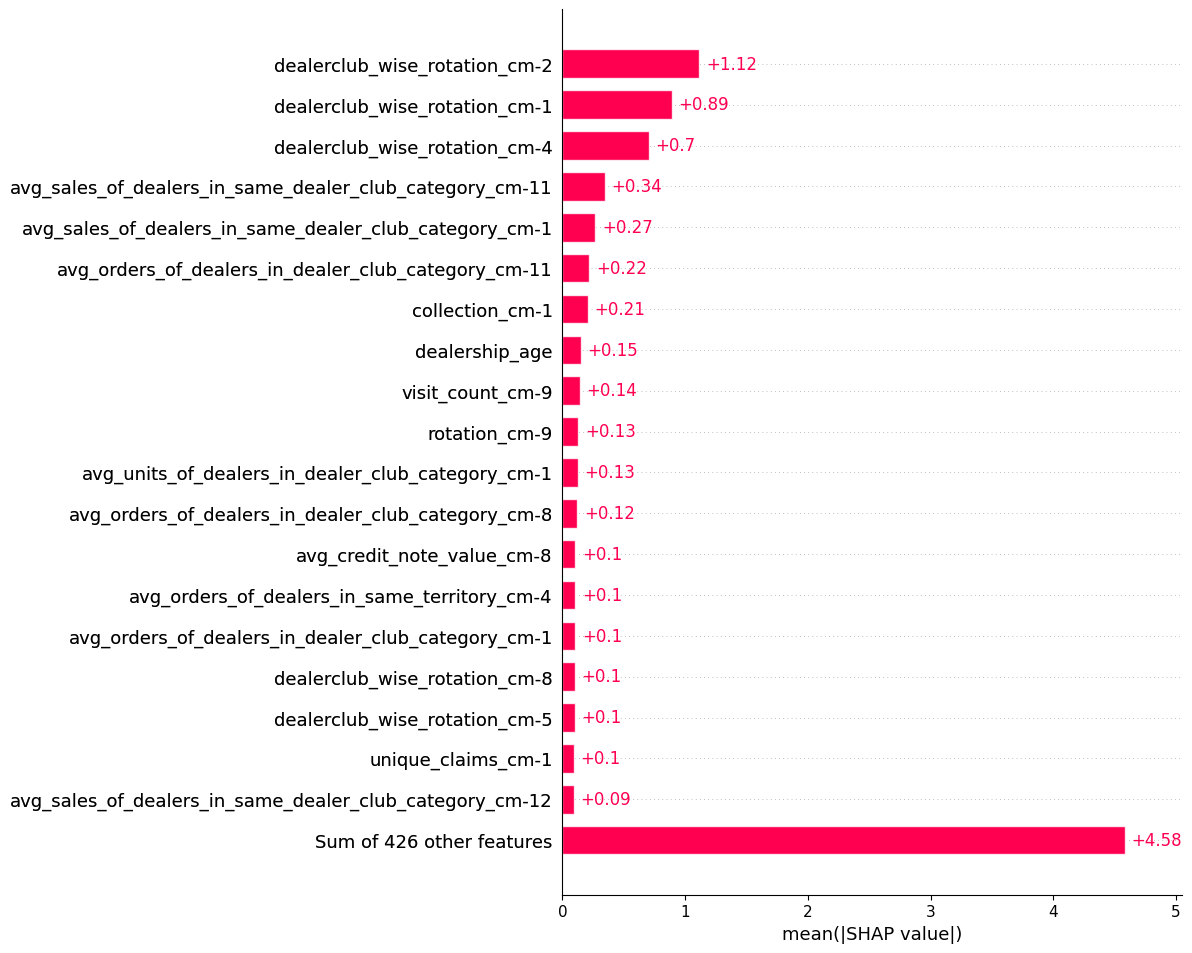

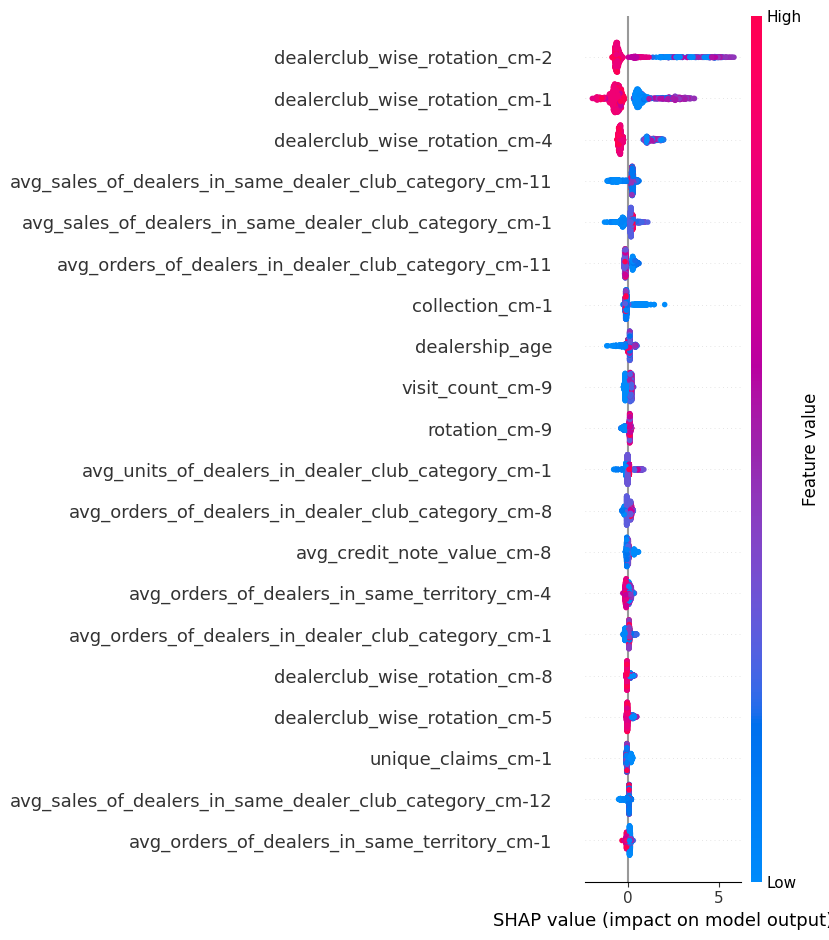

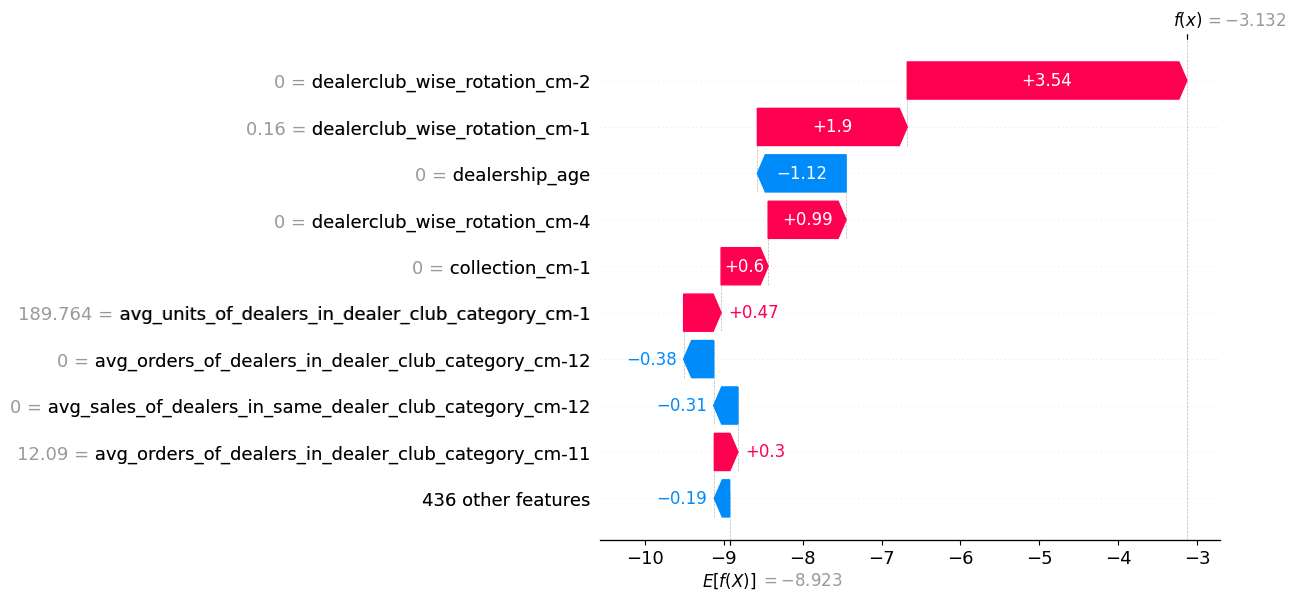

In [39]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Global feature importance
shap.plots.bar(shap_values, max_display=20)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Explain individual prediction
shap.plots.waterfall(shap_values[0])

In [40]:
# --- Ensure DataFrames ---
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train)
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test)

# --- SHAP explainer ---
explainer = shap.TreeExplainer(best_model, X_train)
shap_values = explainer(X_test)

# Handle versions (old vs new SHAP API)
if hasattr(shap_values, "values"):
    shap_values = shap_values.values  

# --- Collect only positive SHAP features for churners ---
results = []
for i, (pred, true) in enumerate(zip(y_pred, y_test)):
    # if pred == 1:  # focus only on predicted churners
    row_idx = X_test.index[i]  # keep original index
    row_shap = shap_values[i]

    feature_importance = pd.DataFrame({
        "feature": X_test.columns,
        "shap_value": row_shap
    })
    
    # Keep only positive features and sort descending
    pos_features = (
        feature_importance[feature_importance["shap_value"] > 0]
        .sort_values(by="shap_value", ascending=False)
    )
    
    results.append({
        "row_index": row_idx,
        "true_label": int(true),
        "pred_label": int(pred),
        "positive_features": dict(zip(pos_features["feature"], pos_features["shap_value"]))
    })

# --- Save results ---
churn_explain_df = pd.DataFrame(results)
churn_explain_df.set_index("row_index", inplace=True)

In [ ]:
raw_features = pd.read_csv("./complete/raw_data.csv")

In [57]:
churn_explain_df.reset_index(inplace=True)

In [60]:
churn_explain_df.rename(columns={"row_index": "dealer_code"}, inplace=True)

In [62]:
testing = pd.merge(raw_features, churn_explain_df, on='dealer_code', how='left')

In [66]:
testing = testing[~testing['true_label'].isna()]

In [ ]:
raw_features.columns[39churnchucwqdWCCDEWDXXEWFAWFFDWDXCSDDWDWSWD NW BDJHGDJEW0:]

Index(['No Change', 'Promoted', 'jktil', 'apollo', 'mrf', 'ceat', 'oth.',
       'total', 'jktil_share', 'apollo_share', 'mrf_share', 'ceat_share',
       'oth._share', 'churn_status', 'zone', 'region_name', 'dealer_count',
       'severity'],
      dtype='object')

In [85]:
raw_features.shape

(6211, 408)

In [ ]:
raw_features[~raw_features['mrf_share'].isna()]['territory_code'].nunique()

5

In [84]:
raw_features[~raw_features['total'].isna()]['territory_code'].nunique()

5

In [97]:
testing['true_label']

4       0.0
5       0.0
6       0.0
11      0.0
18      0.0
       ... 
6190    0.0
6191    0.0
6198    0.0
6200    0.0
6207    0.0
Name: true_label, Length: 1243, dtype: float64

In [100]:
testing['top_features'] = testing.apply(
    lambda row: list(row['positive_features'].keys())[:10] 
                if row['true_label'] == 1 
                else list(row['positive_features'].keys())[-10:], 
    axis=1
)

/var/folders/f7/p98720yn5kn5tvm33x4lx_89rys50w/T/ipykernel_45007/3695956556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['top_features'] = testing.apply(


In [ ]:
# testing.to_csv("./complete/final_data.csv", index=False)

In [42]:
churn_explain_df.loc[1122399]['positive_features']

{'dealerclub_wise_rotation_cm-2': 2.5250664712203434,
 'dealerclub_wise_rotation_cm-1': 1.152991262509022,
 'dealerclub_wise_rotation_cm-4': 0.8889750029169954,
 'collection_cm-1': 0.33617406225879676,
 'avg_orders_of_dealers_in_dealer_club_category_cm-11': 0.2920816584047861,
 'avg_orders_of_dealers_in_dealer_club_category_cm-2': 0.2723776640975848,
 'dealerclub_wise_rotation_cm-3': 0.2197376763788634,
 'avg_sales_of_dealers_in_same_dealer_club_category_cm-1': 0.1984193374181632,
 'avg_units_of_dealers_in_dealer_club_category_cm-1': 0.19050661374465563,
 'dealerclub_wise_rotation_cm-8': 0.17449459195835515,
 'avg_orders_of_dealers_in_dealer_club_category_cm-3': 0.12508447621250526,
 'avg_units_of_dealers_in_dealer_club_category_cm-3': 0.11601910713594407,
 'terrwise_rotation_cm-4': 0.11349196208757348,
 'avg_units_of_dealers_in_same_territory_cm-3': 0.10255993756465615,
 'dealerclub_wise_rotation_cm-5': 0.10045414243999402,
 'terrwise_rotation_cm-12': 0.09296463525621221,
 'avg_sales_

In [106]:
shap_values[1]

.values =
array([-5.97854534e-02,  2.05297287e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.10543646e-01,  0.00000000e+00,  0.00000000e+00,
        5.79430585e-02,  6.43110943e-02,  1.37231657e-02,  0.00000000e+00,
        0.00000000e+00, -1.01926702e-02,  0.00000000e+00, -8.09454364e-02,
       -7.43416931e-02,  0.00000000e+00,  1.23578210e-02,  0.00000000e+00,
        1.10073797e-02, -3.56769715e-03,  0.00000000e+00,  0.00000000e+00,
        1.26660439e-02, -5.35939275e-02,  0.00000000e+00, -1.75137702e-03,
        2.57266932e-02, -6.12161686e-02, -1.04856512e-02,  0.00000000e+00,
       -3.91381647e-03,  7.25873262e-02,  1.01207536e-02, -5.15584227e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000

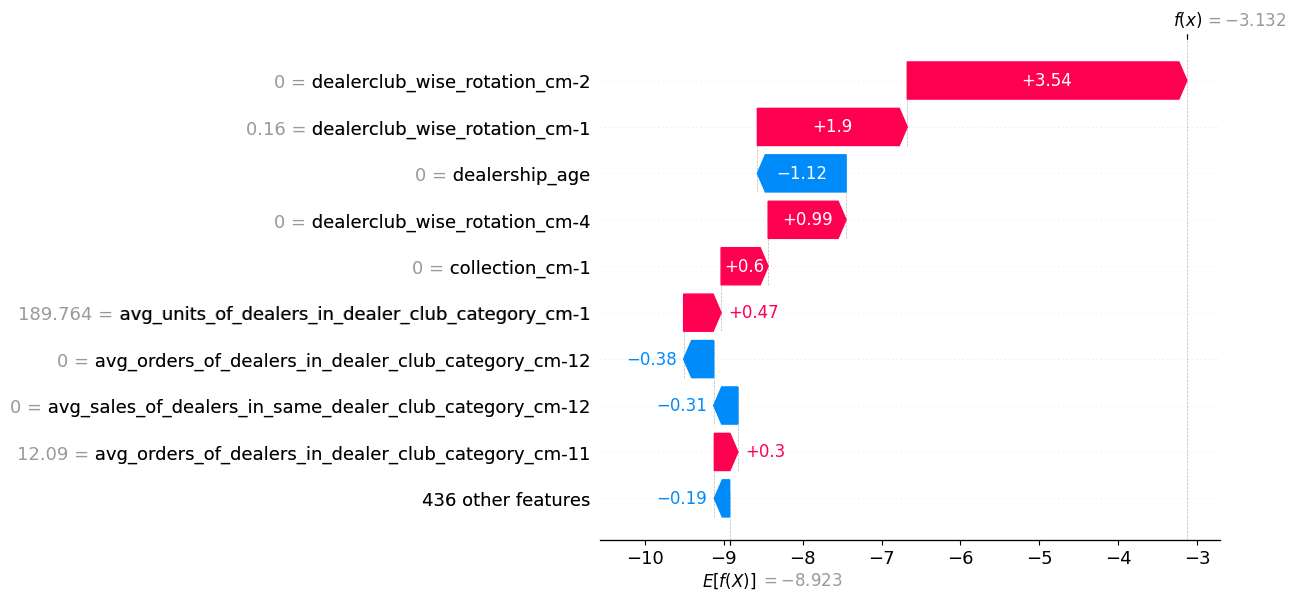

In [104]:
shap.plots.waterfall(shap_values[0])

In [120]:
d = pd.read_csv("offset_features.csv", usecols=['dealer_code', 'last_billed_days'])

In [122]:
X_test = pd.merge(X_test, d, on='dealer_code', how='left')

In [125]:
X_test.sort_values(by='last_billed_days', ascending=True, inplace=True)

In [127]:
X_test[['dealer_code','last_billed_days']]

,dealer_code,last_billed_days
621,1121474,0
205,1121039,0
1144,1123053,0
206,1118955,0
212,1108656,0
...,...,...
409,1105095,361
269,1110181,362
72,1110885,365
383,1120837,365


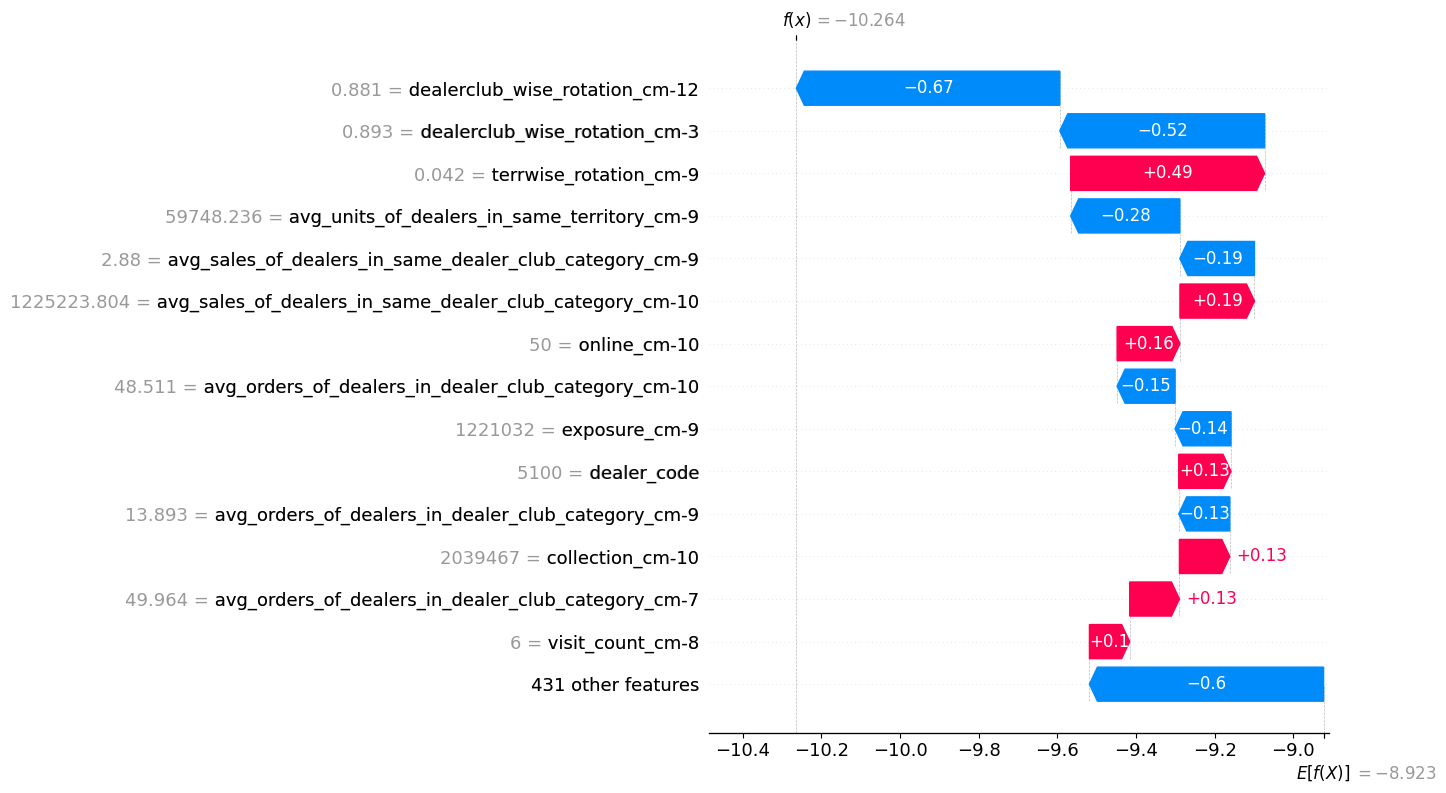

In [134]:
row_idx = 621  

# Extract row
row = X_test.iloc[row_idx]

# Build Explanation object with feature values included
exp = shap.Explanation(
    values = shap_values[row_idx],
    base_values = explainer.expected_value,
    data = row.values,
    feature_names = X_test.columns
)

shap.plots.waterfall(exp, max_display=15, show=True)

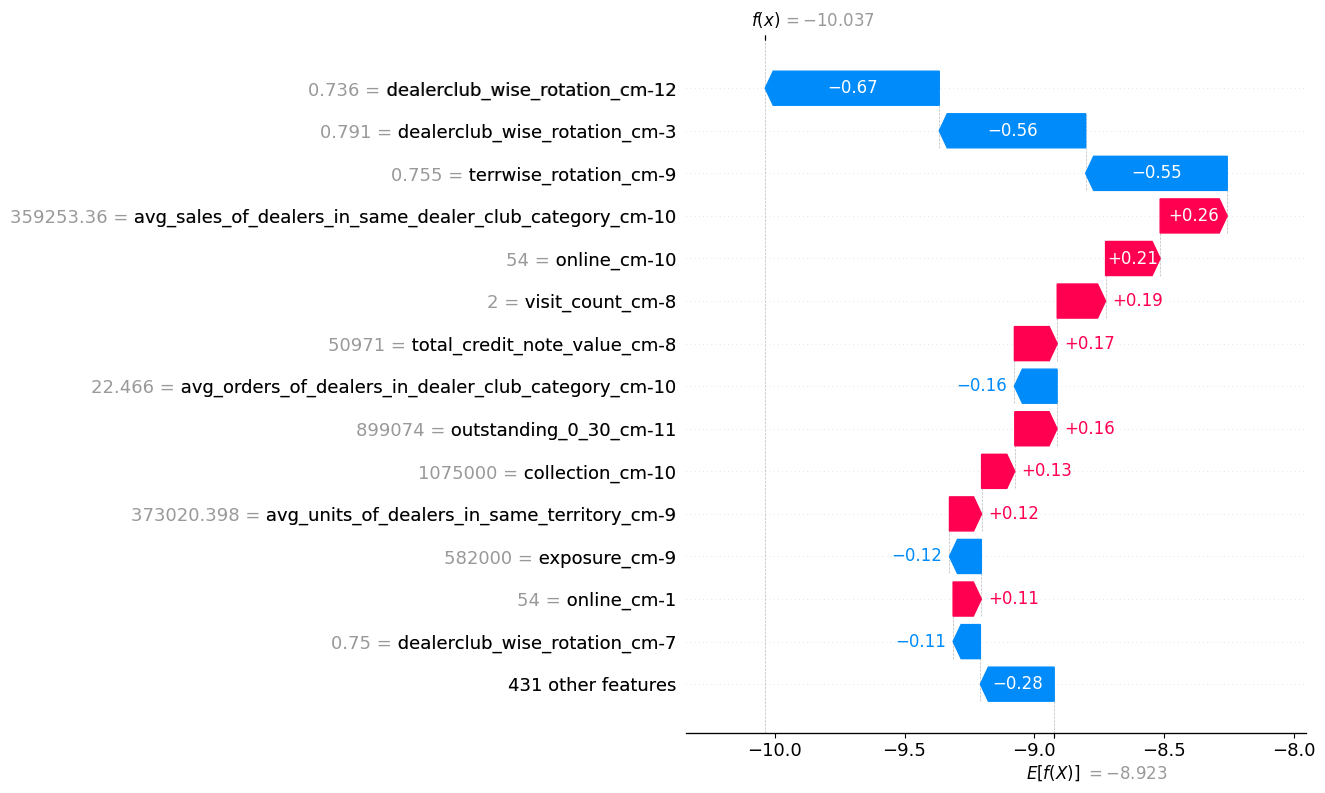

In [132]:
row_idx = 205  

# Extract row
row = X_test.iloc[row_idx]

# Build Explanation object with feature values included
exp = shap.Explanation(
    values = shap_values[row_idx],
    base_values = explainer.expected_value,
    data = row.values,
    feature_names = X_test.columns
)

shap.plots.waterfall(exp, max_display=15, show=True)

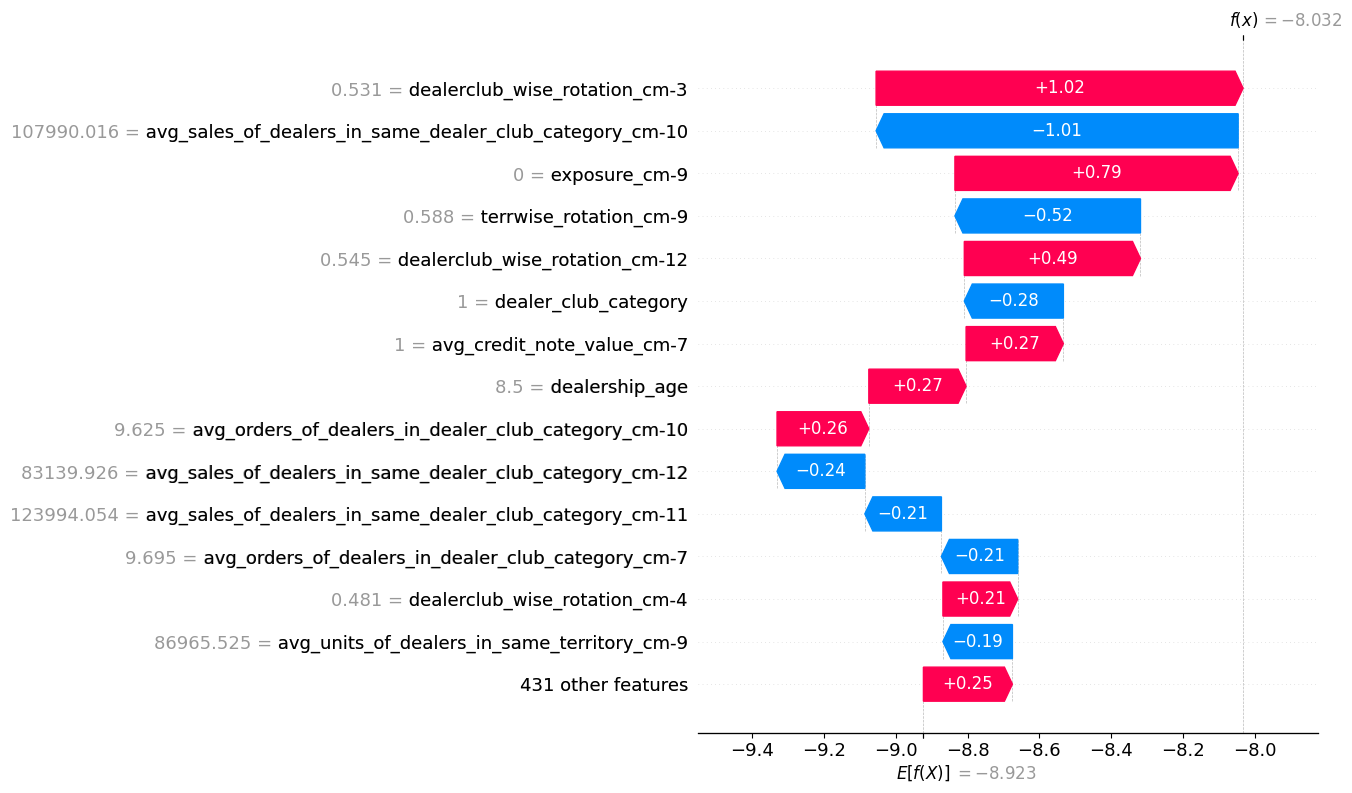

In [135]:
## last billed days 1020

row_idx = 1020  

# Extract row
row = X_test.iloc[row_idx]

# Build Explanation object with feature values included
exp = shap.Explanation(
    values = shap_values[row_idx],
    base_values = explainer.expected_value,
    data = row.values,
    feature_names = X_test.columns
)

shap.plots.waterfall(exp, max_display=15, show=True)

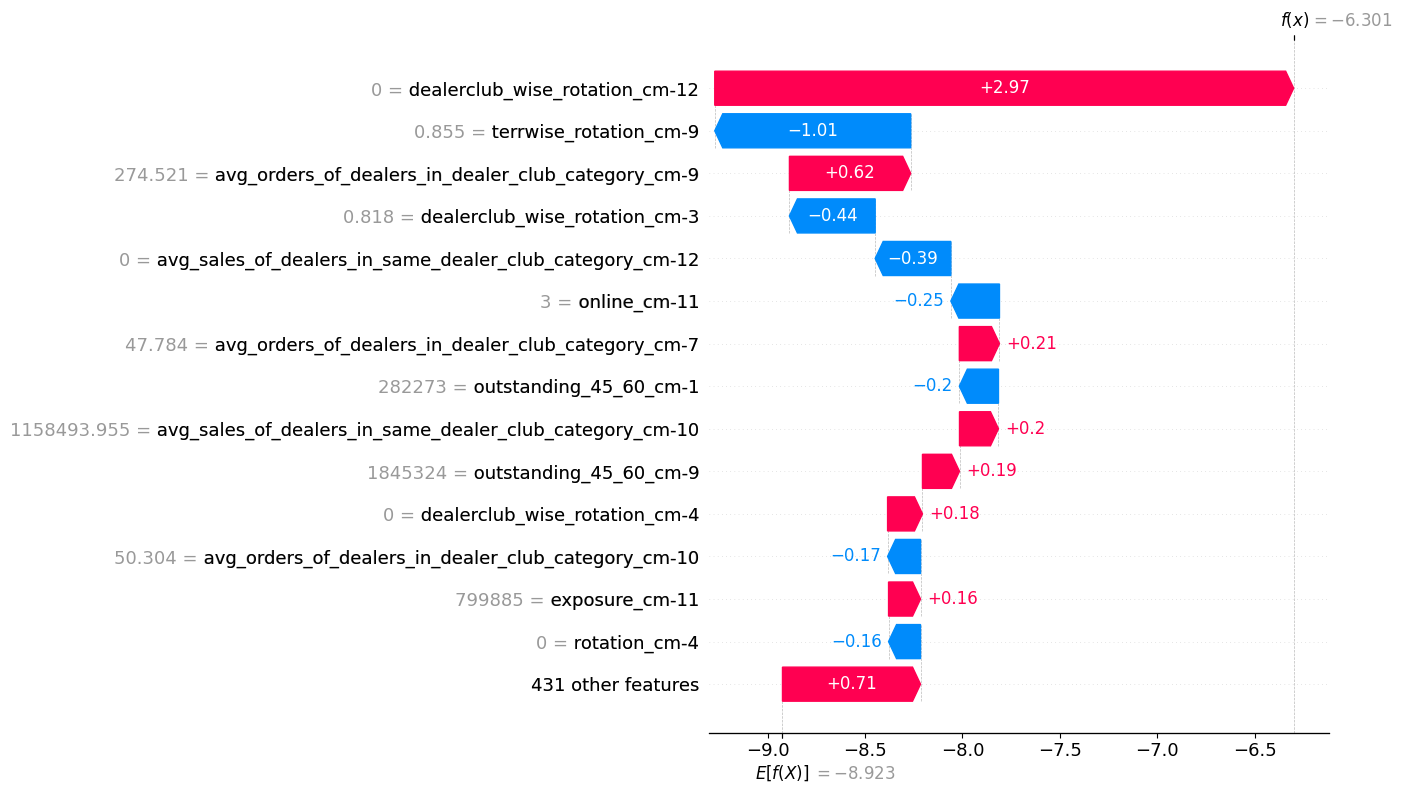

In [137]:
row_idx = 836  

# Extract row
row = X_test.iloc[row_idx]

# Build Explanation object with feature values included
exp = shap.Explanation(
    values = shap_values[row_idx],
    base_values = explainer.expected_value,
    data = row.values,
    feature_names = X_test.columns
)

shap.plots.waterfall(exp, max_display=15, show=True)

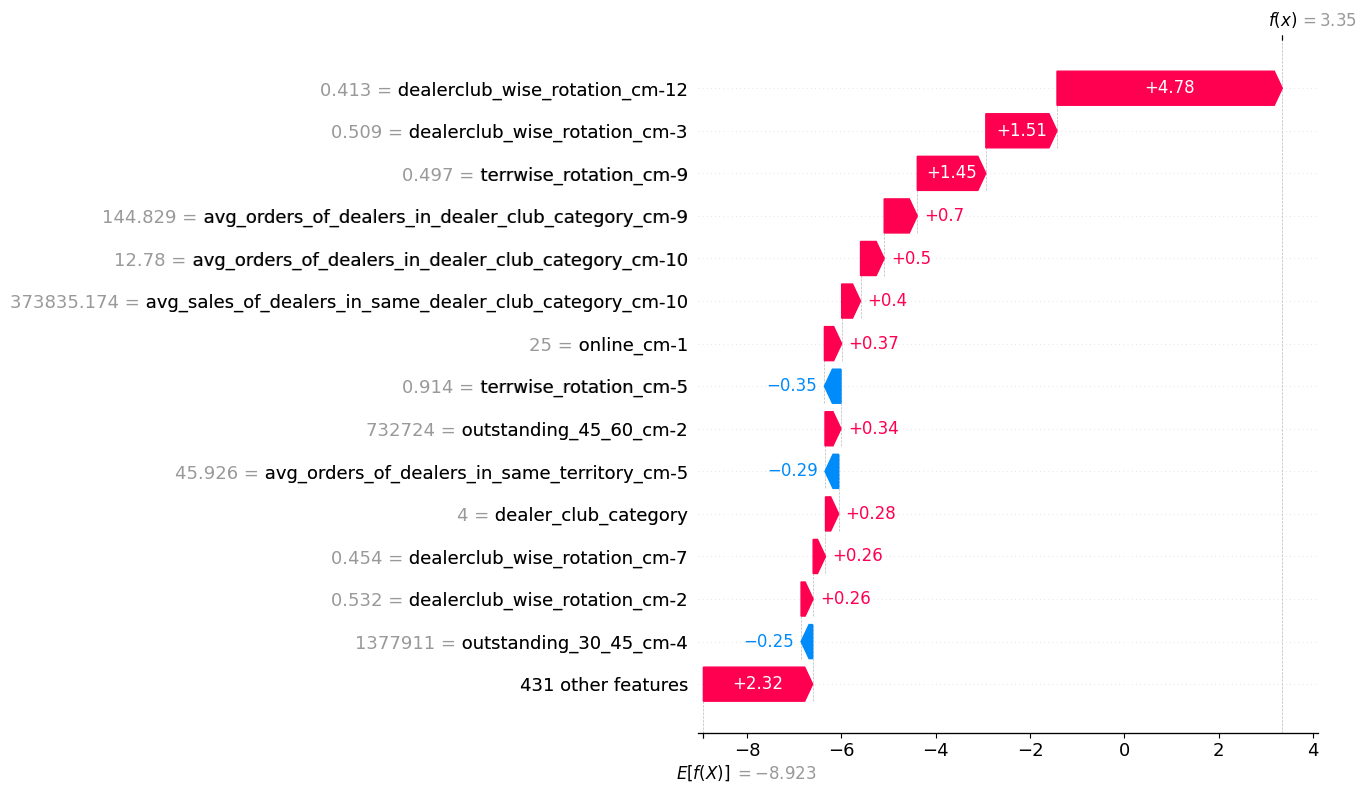

In [139]:
row_idx = 954  

# Extract row
row = X_test.iloc[row_idx]

# Build Explanation object with feature values included
exp = shap.Explanation(
    values = shap_values[row_idx],
    base_values = explainer.expected_value,
    data = row.values,
    feature_names = X_test.columns
)

shap.plots.waterfall(exp, max_display=15, show=True)

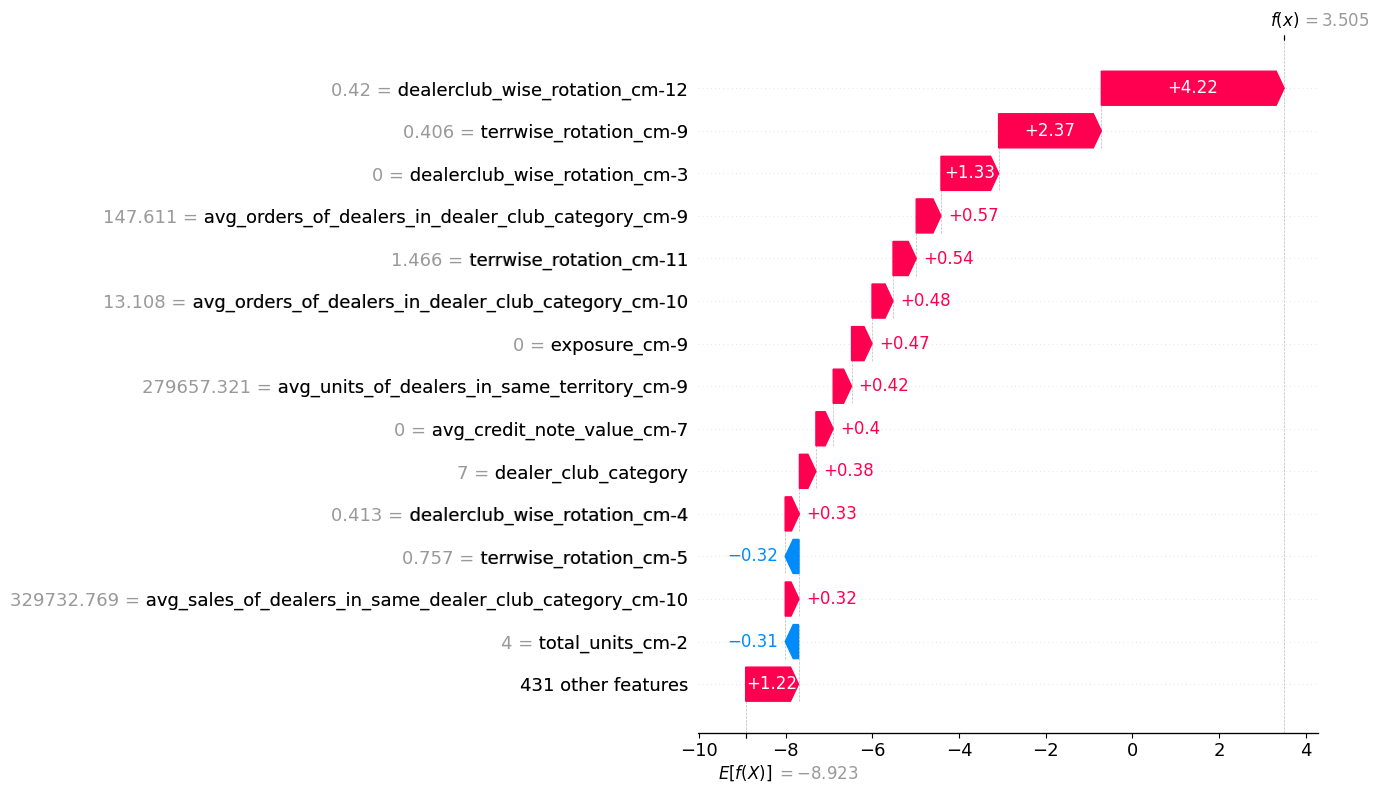

In [140]:
row_idx = 510  

# Extract row
row = X_test.iloc[row_idx]

# Build Explanation object with feature values included
exp = shap.Explanation(
    values = shap_values[row_idx],
    base_values = explainer.expected_value,
    data = row.values,
    feature_names = X_test.columns
)

shap.plots.waterfall(exp, max_display=15, show=True)

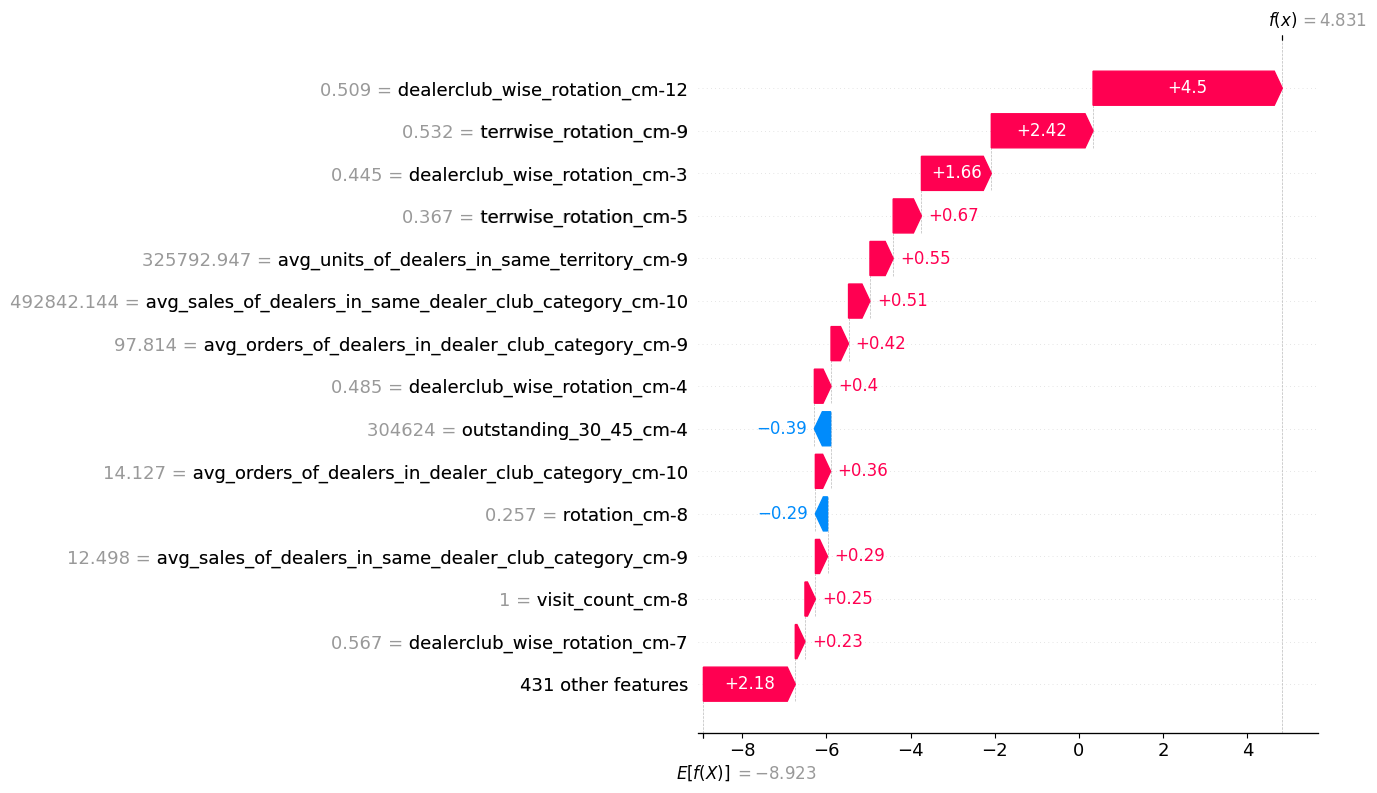

In [141]:
row_idx = 59  

# Extract row
row = X_test.iloc[row_idx]

# Build Explanation object with feature values included
exp = shap.Explanation(
    values = shap_values[row_idx],
    base_values = explainer.expected_value,
    data = row.values,
    feature_names = X_test.columns
)

shap.plots.waterfall(exp, max_display=15, show=True)

In [145]:
import joblib

# -------- Save Model --------
joblib.dump(best_model, "./complete/xgb_churn_model.pkl")

# # -------- Load Model --------
# loaded_model = joblib.load("./complete/xgb_churn_model.pkl")

# # -------- Test Loaded Model --------
# y_pred_loaded = loaded_model.predict(X_test)


['./complete/xgb_churn_model.pkl']

In [143]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

## What is shap?

### SHAP (SHapley Additive exPlanations) helps us open up the black box by showing the contribution of each feature to a prediction.

## How to Interpret SHAP Values

### 1.  Direction:

#### A positive SHAP value pushes the prediction towards churn.

#### A negative SHAP value pushes it towards retention.

### 2. Magnitude:

#### The bigger the SHAP value, the stronger the impact of that feature on the prediction.

#### Example: A SHAP value of +0.8 for “Drop in Monthly Sales” means sales decline strongly contributed to predicting churn.

### 3. Per Dealer Insight:

#### For each dealer, we can list the top factors that drove the churn prediction (e.g., sales drop, fewer visits, high claims).

#### This lets sales teams see the “why” for each dealer and design targeted interventions.

### 4. Aggregate Insight:

#### Across all dealers, we can also see which features are most frequently important for churn (like sales trend, claim severity, visit frequency).

### This helps leadership prioritize business levers.

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)  # SHAP values for test data


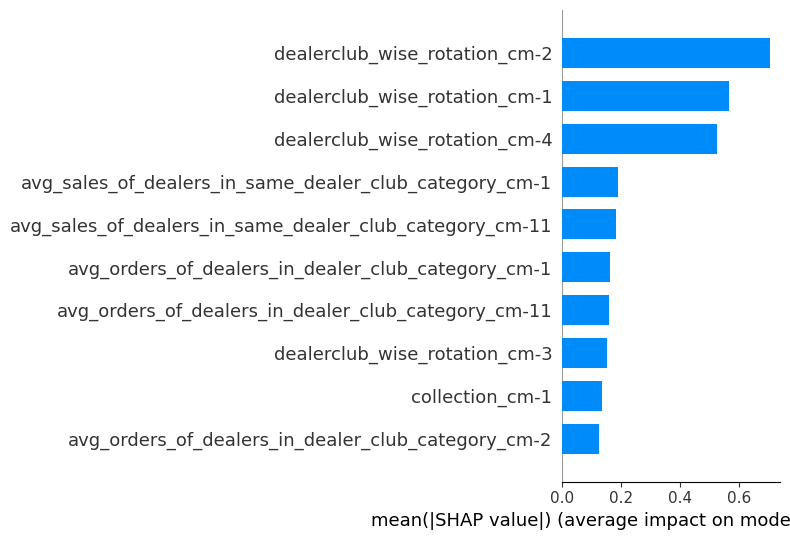

In [43]:
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

In [46]:
shap_value = shap_values[1][0]  # SHAP values for class 1 (churn) for the first instance

In [ ]:
shap.plots.waterfall(
    shap.Explanation(
         values=shap_values[shap_value],
         base_values=explainer.expected_value,
         data=X_test.iloc[shap_value].values,
         feature_names=X_test.columns
     )
)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
churn_explain_df

,true_label,pred_label,positive_features
row_index,,,
1120668,1,1,{'dealerclub_wise_rotation_cm-2': 2.8485843516...
1117092,1,1,{'dealerclub_wise_rotation_cm-2': 2.6122813968...
1120067,1,1,{'dealerclub_wise_rotation_cm-2': 3.3884989385...
1103246,1,1,{'dealerclub_wise_rotation_cm-2': 2.9631903691...
1117865,1,1,{'dealerclub_wise_rotation_cm-2': 2.7935636416...
...,...,...,...
1110206,1,1,{'dealerclub_wise_rotation_cm-2': 2.4754178776...
1101692,1,1,{'dealerclub_wise_rotation_cm-2': 2.9617175223...
1119231,1,1,{'dealerclub_wise_rotation_cm-2': 2.7302250018...


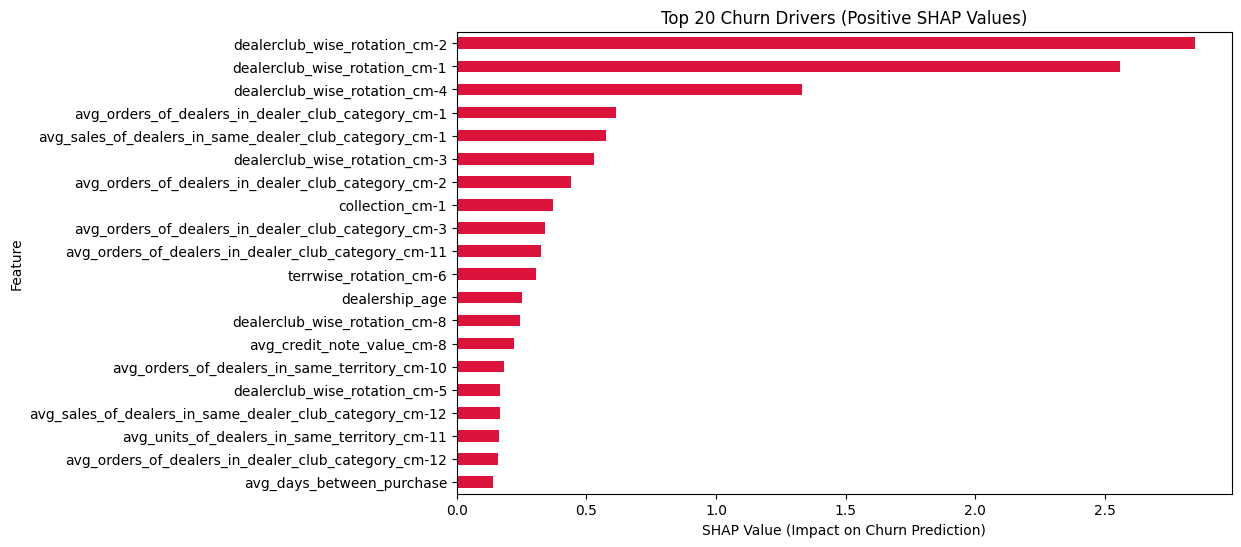

In [ ]:
# Convert shap values to a DataFrame (keeping index for mapping back to rows)
shap_df = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)

# Select the dealer/row you want to explain (example: dealer_id = 1234)
row_id = 1120668
row_shap = shap_df.loc[row_id]

# Filter only positive (churn-increasing) features
positive_shap = row_shap[row_shap > 0]

# Sort in descending order and pick top 20
top20_positive = positive_shap.sort_values(ascending=False).head(20)

# Plot as horizontal bar chart
plt.figure(figsize=(10, 6))
top20_positive[::-1].plot(kind="barh", color="crimson")  # reversed for top-down
plt.title("Top 20 Churn Drivers (Positive SHAP Values)")
plt.xlabel("SHAP Value (Impact on Churn Prediction)")
plt.ylabel("Feature")
plt.show()


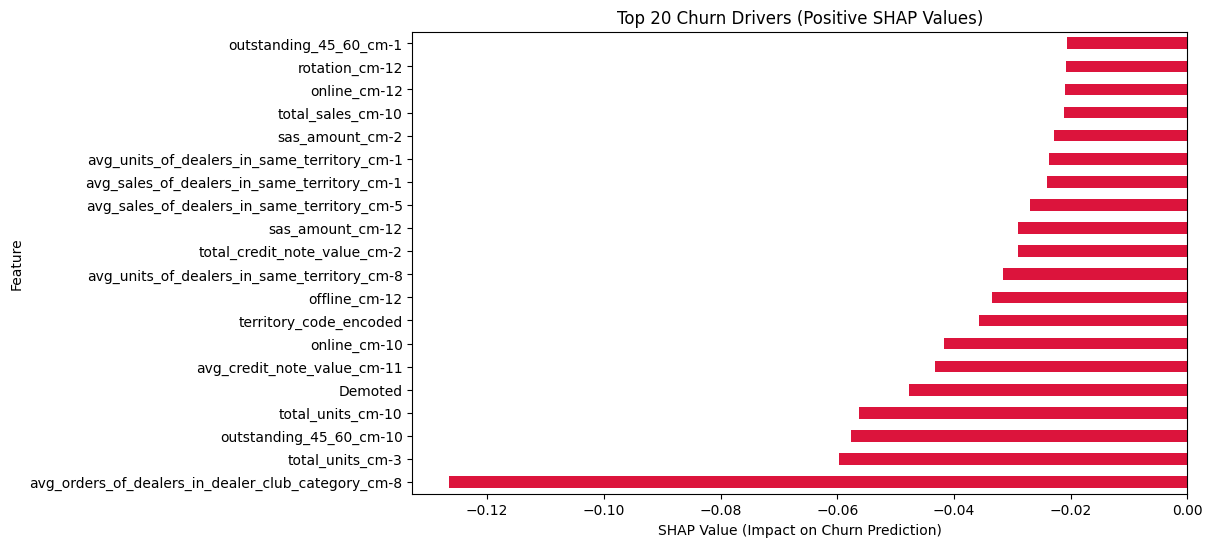

In [ ]:
# Convert shap values to a DataFrame (keeping index for mapping back to rows)
shap_df = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)

# Select the dealer/row you want to explain (example: dealer_id = 1234)
row_id = 1120668
row_shap = shap_df.loc[row_id]

# Filter only positive (churn-increasing) features
positive_shap = row_shap[row_shap < 0]

# Sort in descending order and pick top 20
top20_positive = positive_shap.sort_values(ascending=False).tail(20)

# Plot as horizontal bar chart
plt.figure(figsize=(10, 6))
top20_positive[::-1].plot(kind="barh", color="crimson")  # reversed for top-down
plt.title("Top 20 Churn Drivers (Positive SHAP Values)")
plt.xlabel("SHAP Value (Impact on Churn Prediction)")
plt.ylabel("Feature")
plt.show()


In [ ]:
churn_explain_df['positive_features'][1120668]

{'dealerclub_wise_rotation_cm-2': 2.848584351632744,
 'dealerclub_wise_rotation_cm-1': 2.55979879216291,
 'dealerclub_wise_rotation_cm-4': 1.3331812022440135,
 'avg_orders_of_dealers_in_dealer_club_category_cm-1': 0.6120944042527117,
 'avg_sales_of_dealers_in_same_dealer_club_category_cm-1': 0.5739483540772926,
 'dealerclub_wise_rotation_cm-3': 0.5291768182371743,
 'avg_orders_of_dealers_in_dealer_club_category_cm-2': 0.44030412004329267,
 'collection_cm-1': 0.37277553898631594,
 'avg_orders_of_dealers_in_dealer_club_category_cm-3': 0.3390212455810979,
 'avg_orders_of_dealers_in_dealer_club_category_cm-11': 0.32277600184781474,
 'terrwise_rotation_cm-6': 0.30372018546389884,
 'dealership_age': 0.2528030562098138,
 'dealerclub_wise_rotation_cm-8': 0.24385274151340128,
 'avg_credit_note_value_cm-8': 0.21980730140814558,
 'avg_orders_of_dealers_in_same_territory_cm-10': 0.18021331852592992,
 'dealerclub_wise_rotation_cm-5': 0.1650719255465083,
 'avg_sales_of_dealers_in_same_dealer_club_ca

In [ ]:
X_test.loc[1120668]

total_sales_cm-1          82407.0
total_sales_cm-10         39720.0
total_sales_cm-11         32250.0
total_sales_cm-12         29790.0
total_sales_cm-2              0.0
                           ...   
region_name_Siliguri          0.0
region_name_Udaipur           0.0
region_name_VARANASI          0.0
region_name_VIJAYAWADA        0.0
territory_code_encoded      150.0
Name: 1120668, Length: 445, dtype: float64

,total_sales_cm-1,total_sales_cm-10,total_sales_cm-11,total_sales_cm-12,total_sales_cm-2,total_sales_cm-3,total_sales_cm-4,total_sales_cm-5,total_sales_cm-6,total_sales_cm-7,...,region_name_PUNE,region_name_RAIPUR,region_name_RAJKOT,region_name_SALEM,region_name_SURAT,region_name_Siliguri,region_name_Udaipur,region_name_VARANASI,region_name_VIJAYAWADA,territory_code_encoded
dealer_code,,,,,,,,,,,,,,,,,,,,,
1100001,453904.0,471263.0,704437.0,414471.0,235877.0,350517.0,337935.0,147713.0,164122.0,213760.0,...,0,0,0,0,0,0,0,0,0,41
1100011,101965.0,2344175.0,2452512.0,3137421.0,2305612.0,4065420.0,3498898.0,2208608.0,2390135.0,3155005.0,...,0,0,0,0,0,0,0,0,0,42
1100014,23212.0,63134.0,125129.0,88541.0,0.0,0.0,0.0,15200.0,40714.0,51445.0,...,0,0,0,0,0,0,0,0,0,41
1100015,416390.0,494390.0,485150.0,284870.0,409925.0,412295.0,527260.0,480790.0,421280.0,490020.0,...,0,0,0,0,0,0,0,0,0,41
1100030,119842.0,137136.0,60960.0,166486.0,177107.0,84029.0,76575.0,79583.0,62617.0,70868.0,...,0,0,0,0,0,0,0,0,0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123081,29712.0,0.0,0.0,0.0,177886.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,57
1123085,28360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,143
1123090,166447.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,184


In [ ]:
churn_explain_df['positive_features'][1120668]

{'dealerclub_wise_rotation_cm-2': 2.848584351632744,
 'dealerclub_wise_rotation_cm-1': 2.55979879216291,
 'dealerclub_wise_rotation_cm-4': 1.3331812022440135,
 'avg_orders_of_dealers_in_dealer_club_category_cm-1': 0.6120944042527117,
 'avg_sales_of_dealers_in_same_dealer_club_category_cm-1': 0.5739483540772926,
 'dealerclub_wise_rotation_cm-3': 0.5291768182371743,
 'avg_orders_of_dealers_in_dealer_club_category_cm-2': 0.44030412004329267,
 'collection_cm-1': 0.37277553898631594,
 'avg_orders_of_dealers_in_dealer_club_category_cm-3': 0.3390212455810979,
 'avg_orders_of_dealers_in_dealer_club_category_cm-11': 0.32277600184781474,
 'terrwise_rotation_cm-6': 0.30372018546389884,
 'dealership_age': 0.2528030562098138,
 'dealerclub_wise_rotation_cm-8': 0.24385274151340128,
 'avg_credit_note_value_cm-8': 0.21980730140814558,
 'avg_orders_of_dealers_in_same_territory_cm-10': 0.18021331852592992,
 'dealerclub_wise_rotation_cm-5': 0.1650719255465083,
 'avg_sales_of_dealers_in_same_dealer_club_ca

In [ ]:
churn_explain_df['top_features'][1]

{'dealerclub_wise_rotation_cm-2': 2.6122813968197445,
 'dealerclub_wise_rotation_cm-1': 2.4164705311512806,
 'dealerclub_wise_rotation_cm-4': 1.0687973289377988,
 'avg_days_between_purchase': 0.6813278682669625,
 'dealerclub_wise_rotation_cm-3': 0.5100134719064227,
 'avg_orders_of_dealers_in_dealer_club_category_cm-1': 0.5093109865696169,
 'avg_sales_of_dealers_in_same_dealer_club_category_cm-1': 0.36820876675192266,
 'avg_orders_of_dealers_in_dealer_club_category_cm-2': 0.3670744776772335,
 'avg_sales_of_dealers_in_same_dealer_club_category_cm-11': -0.3143664720701054,
 'avg_sales_of_dealers_in_same_dealer_club_category_cm-12': -0.3056856697076}

In [ ]:
churn_explain_df['top_features'][2]

{'dealerclub_wise_rotation_cm-2': 3.388498938581906,
 'dealerclub_wise_rotation_cm-1': 2.029308896678267,
 'dealerclub_wise_rotation_cm-4': 1.4901377578801476,
 'avg_sales_of_dealers_in_same_dealer_club_category_cm-1': 0.5863704798230901,
 'dealerclub_wise_rotation_cm-3': 0.5167674537561834,
 'avg_orders_of_dealers_in_dealer_club_category_cm-1': 0.47913600252824834,
 'avg_orders_of_dealers_in_dealer_club_category_cm-2': 0.42747046576347203,
 'avg_orders_of_dealers_in_dealer_club_category_cm-11': 0.37067742906394413,
 'avg_orders_of_dealers_in_dealer_club_category_cm-3': 0.3627540002495516,
 'terrwise_rotation_cm-6': 0.3612885621644091}

In [73]:
importances = {}
for col, imp in zip(X.columns, models["Random Forest"].feature_importances_):
    importances[col] = imp

In [74]:
dict(sorted(importances.items(), key= lambda x: x[1], reverse=True))

{'dealerclub_wise_rotation_cm-3': 0.06081940345824536,
 'avg_orders_of_dealers_in_dealer_club_category_cm-2': 0.05986225711659842,
 'dealerclub_wise_rotation_cm-4': 0.05017629922443028,
 'dealerclub_wise_rotation_cm-2': 0.04991114799295355,
 'dealerclub_wise_rotation_cm-7': 0.04184098210476035,
 'dealerclub_wise_rotation_cm-1': 0.03648731956081276,
 'avg_orders_of_dealers_in_dealer_club_category_cm-7': 0.03398247349274147,
 'avg_orders_of_dealers_in_dealer_club_category_cm-3': 0.0327308655488667,
 'avg_orders_of_dealers_in_dealer_club_category_cm-5': 0.030267449290515967,
 'dealerclub_wise_rotation_cm-6': 0.027107658236446536,
 'avg_orders_of_dealers_in_dealer_club_category_cm-12': 0.024132563821484265,
 'avg_orders_of_dealers_in_dealer_club_category_cm-6': 0.022598393704839577,
 'avg_orders_of_dealers_in_dealer_club_category_cm-10': 0.021999955006815706,
 'avg_orders_of_dealers_in_dealer_club_category_cm-9': 0.02191951769444269,
 'avg_orders_of_dealers_in_dealer_club_category_cm-11': 

In [75]:
import plotly.express as px

px.bar(x = importances.keys(), y = importances.values())

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['total_sales_cm-1', 'total_sales_cm-10', 'total_sales_cm-11', ...,
                          'region_name_VARANASI', 'region_name_VIJAYAWADA',
                          'territory_code_encoded'], dtype=object),
              'xaxis': 'x',
              'y': {'bdata': ('EtYlkP20Wj/V+7kYRXUmPxJ+iDjSWS' ... 'BaPmryPlNllt8Moyo/gHb/DXMBUT8='),
                    'dtype': 'f8'},
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

estimator = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
cv = StratifiedKFold(5)

rfecv = RFECV(estimator=estimator, step=10, cv=cv, scoring='roc_auc', n_jobs=-1)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")
selected_features = X.columns[rfecv.support_]
print("Selected Features:", list(selected_features))

Optimal number of features: 115
Selected Features: ['total_sales_cm-1', 'total_sales_cm-11', 'total_sales_cm-12', 'total_sales_cm-3', 'total_invoices_cm-12', 'total_units_cm-1', 'total_units_cm-2', 'total_units_cm-3', 'avg_sales_cm-1', 'avg_sales_cm-4', 'avg_sales_cm-7', 'avg_units_purchased_cm-1', 'avg_units_purchased_cm-9', 'avg_sales_of_dealers_in_same_territory_cm-1', 'avg_sales_of_dealers_in_same_territory_cm-10', 'avg_sales_of_dealers_in_same_territory_cm-11', 'avg_sales_of_dealers_in_same_territory_cm-12', 'avg_sales_of_dealers_in_same_territory_cm-3', 'avg_sales_of_dealers_in_same_territory_cm-9', 'avg_orders_of_dealers_in_same_territory_cm-1', 'avg_orders_of_dealers_in_same_territory_cm-10', 'avg_orders_of_dealers_in_same_territory_cm-11', 'avg_orders_of_dealers_in_same_territory_cm-12', 'avg_orders_of_dealers_in_same_territory_cm-2', 'avg_orders_of_dealers_in_same_territory_cm-3', 'avg_orders_of_dealers_in_same_territory_cm-4', 'avg_orders_of_dealers_in_same_territory_cm-7', 

In [77]:
from xgboost import XGBClassifier
import numpy as np

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight= ( (len(y) - sum(y)) / sum(y) ))
model.fit(X, y)

importances = model.feature_importances_
threshold = np.percentile(importances, 75)  # take top 25% features by importance
selected_idx = np.where(importances >= threshold)[0]
selected_features = X.columns[selected_idx]

print(f"Selected top 25% features by importance: {len(selected_features)}")
print(selected_features)


/Users/lakshita.kain/Desktop/jk/dealer_churn_model/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[22:30:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Selected top 25% features by importance: 112
Index(['total_sales_cm-10', 'total_sales_cm-2', 'total_sales_cm-5',
       'total_sales_cm-7', 'total_sales_cm-9', 'total_invoices_cm-1',
       'total_invoices_cm-10', 'total_invoices_cm-3', 'total_invoices_cm-6',
       'total_invoices_cm-7',
       ...
       'active_claims_cm-10', 'active_claims_cm-9', 'visit_count_cm-10',
       'visit_count_cm-5', 'visit_count_cm-7', 'dealership_age', 'No Change',
       'dealer_count', 'zone_EAST', 'territory_code_encoded'],
      dtype='object', length=112)


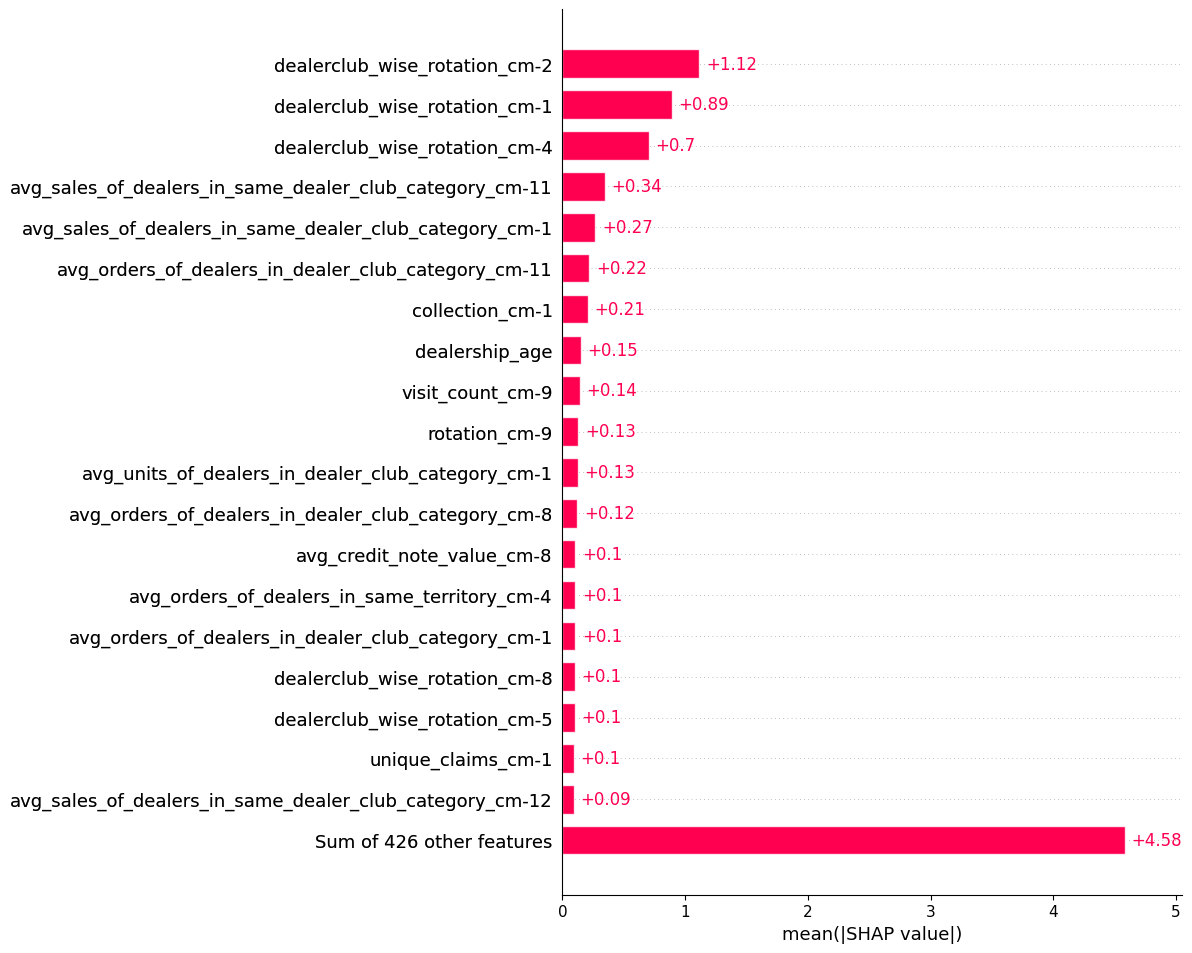

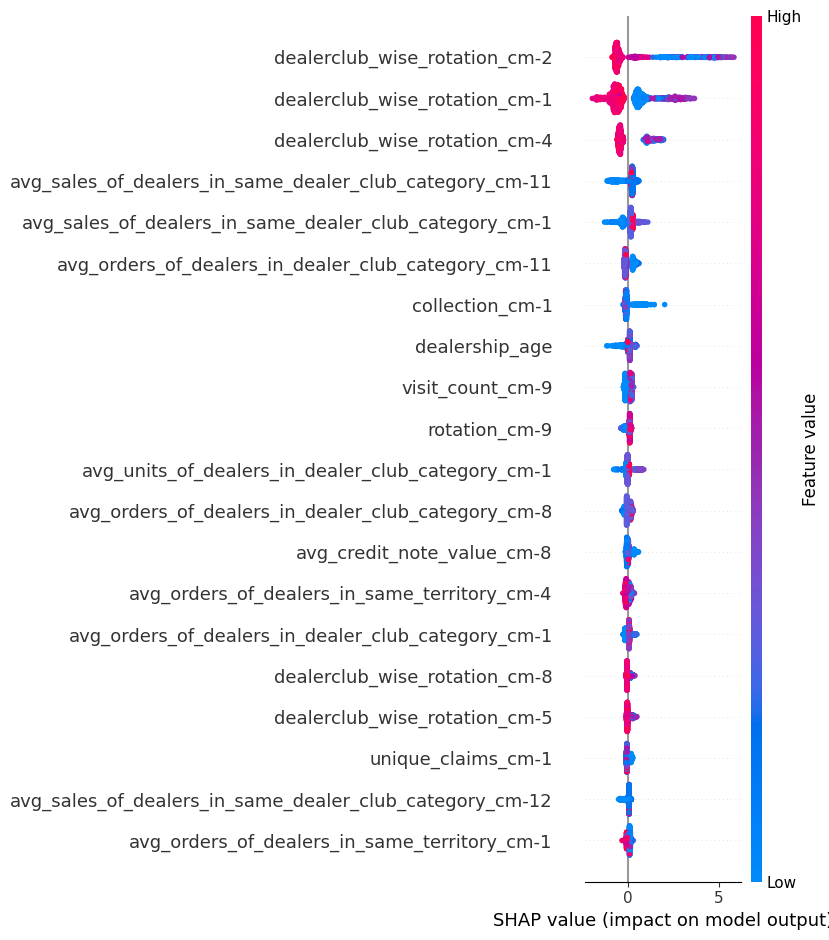

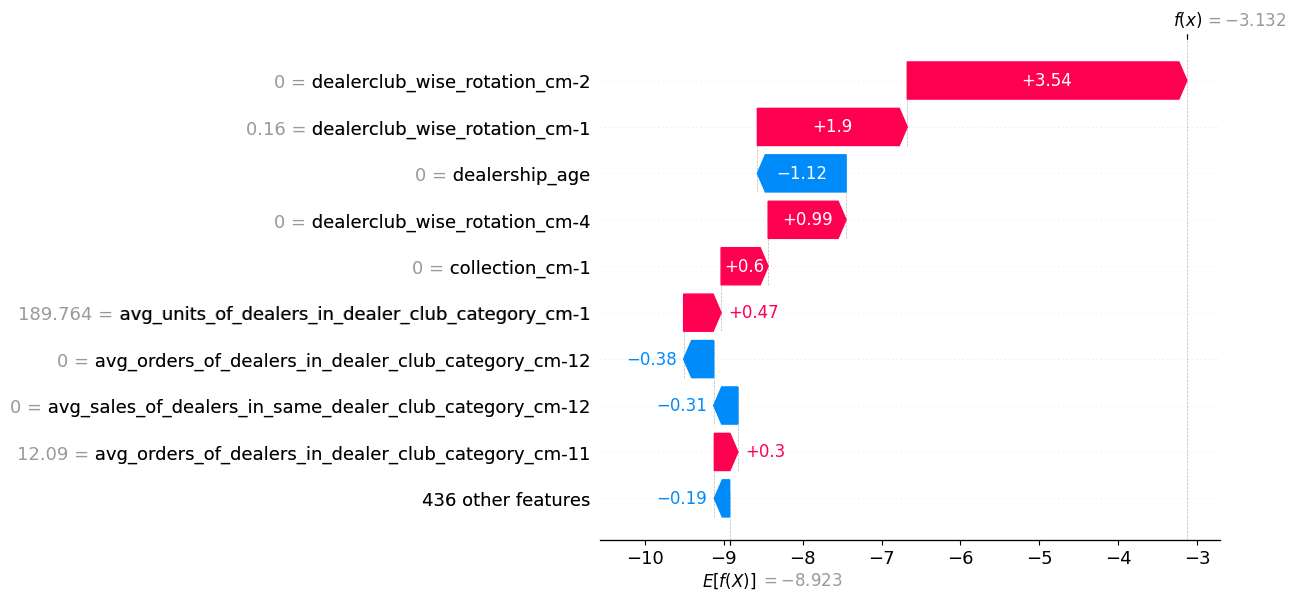

In [102]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Global feature importance
shap.plots.bar(shap_values, max_display=20)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Explain individual prediction
shap.plots.waterfall(shap_values[0])

In [103]:
len(X_test), len(y_pred),len(y_proba)

(1243, 1243, 1243)

In [ ]:
X_test['pred_label'] = y_pred
X_test['confidence_score'] =  y_proba

X_test['confidence_score'] = X_test['confidence_score'].apply(lambda x: 0 if x < 0.0001 else x)
X_test['confidence_score'] = X_test['confidence_score'].round(5)

In [ ]:
X_test['confidence_score'].describe()

count    1243.000000
mean        0.097455
std         0.294900
min         0.000110
25%         0.000110
50%         0.000170
75%         0.000260
max         0.999120
Name: confidence_score, dtype: float64

In [ ]:
# Get top 5 dealers with highest total SHAP value
shap_sum = np.abs(shap_values).sum(axis=1)
top_5_indices = np.argsort(shap_sum)[-5:][::-1]

# Show top features for each
for i, idx in enumerate(top_5_indices):
    print(f"\nDealer {i+1} (Index {idx}) Top Features:")
    dealer_shap = dict(zip(X.columns, shap_values[idx]))
    top_feats = sorted(dealer_shap.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
    for feat, val in top_feats:
        print(f"{feat}: {val:.4f}")




# Reset top_5_indices to match test set indexing
shap_row_count = shap_values.shape[0]
top_5_indices = [i for i in top_5_indices if i < shap_row_count]


for i in range(len(top_5_indices)):
    print(f"\nDealer {i+1} Top Features:")
    row_values = shap_values[i].values
    feature_names = shap_values.feature_names

    top_feats = sorted(zip(feature_names, row_values), key=lambda x: abs(x[1]), reverse=True)[:10]
    for feat, val in top_feats:
        print(f"{feat}: {val:.4f}")


TypeError: bad operand type for abs(): 'Explanation'

In [ ]:
## Last billed days remove
## 